# LDSI Code & Experiment

## Import dependency

In [1]:
import spacy
import json
import random
import re
import os
import pandas as pd
import numpy as np
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import fasttext
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import pickle
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, HYPHENS
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

%load_ext autoreload
%autoreload 2

## Phase 7: Code Deliverable & Instructions

### Set up tokenizer

In [2]:
standard_segmenter = spacy.load("en_core_web_sm")
standard_segmenter.disable_pipes('parser')

standard_segmenter.tokenizer.add_special_case('Vet.App.', [{ORTH: 'Vet.App.'}])
standard_segmenter.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
standard_segmenter.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])
standard_segmenter.tokenizer.add_special_case('Fed.Cir.', [{ORTH: 'Fed.Cir.'}])
standard_segmenter.tokenizer.add_special_case("service'-", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "-"}])
standard_segmenter.tokenizer.add_special_case("service'-the", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "-"}, {ORTH: "the"}])
standard_segmenter.tokenizer.add_special_case("service'--the", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "--"}, {ORTH: "the"}])
standard_segmenter.tokenizer.add_special_case('service"-', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '-'}])
standard_segmenter.tokenizer.add_special_case('service"-the', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '-'}, {ORTH: 'the'}])
standard_segmenter.tokenizer.add_special_case('service"--the', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '--'}, {ORTH: 'the'}])

# Modify tokenizer infix patterns to not seperate on '-'
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
standard_segmenter.tokenizer.infix_finditer = infix_re.finditer

### Some helper functions to run *analyze(str)*

In [3]:
from luima_sbd.sbd_utils import text2sentences
luima_segmenter = text2sentences

def spacy_tokenize(txt):
    doc = standard_segmenter(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        #remove punctuation
        if t.pos_ == 'PUNCT':
            pass
        #remove space, i.e., \r', '\t', '\n'
        elif t.pos_ == 'SPACE':
            pass
        #'three'-NUM5
        elif t.pos_ == 'NUM' and t.is_digit == True:
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_.lower())
    return clean_tokens

def get_word_emdedding(spans, model):
    embedding_list = []
    for s in spans:
        tokens = spacy_tokenize(s)
        embedding = 0
        for t in tokens:
            embedding = embedding + model.get_word_vector(t)
        embedding_list.append(embedding/len(tokens))
    return np.array(embedding_list)

def make_features(spans, model):
    sentence_embedding = get_word_emdedding(spans, model)
    mean = 21.48538961038961
    std = 16.075128094247717
    num_tokens = np.array([len(spacy_tokenize(s)) for s in spans])
    num_tokens_normalized = np.array([ (n-mean)/std for n in num_tokens ])
    start_mean = 0.44916800443681015
    starts_normalized = start_mean*np.ones(len(spans))
    
    features = np.concatenate((sentence_embedding, np.expand_dims(starts_normalized, axis=1), 
                        np.expand_dims(num_tokens_normalized, axis=1)), axis=1)
    return features

def analyze(str):
    '''
    input: single text strin
    return: a list of split sentences along with the name of types they have been classified as
    '''
    sents = luima_segmenter(str, offsets=False)
    features = make_features(sents, embeddings)
    pred = clf.predict(features)
    for i in range(len(sents)):
        print('[',i+1,']',sents[i], '\t\tPredict: ', pred[i])

def setup(clf_path, embedding_path):
    clf = pickle.load(open(clf_path, 'rb'))
    #uncomment the line below to avoid warning
    #fasttext.FastText.eprint = lambda x: None
    embeddings = fasttext.load_model(embedding_path)
    return clf, embeddings


### Analyze the work

In [5]:
#set model path
clf_path = './model/embedding_clf_rf.p'

#use the full path if model can't be loaded
embedding_path = './model/fasttext_cbow.bin'
#embedding_path = '/Users/xiuxiu/Desktop/LDSI/Project/code/model/fasttext_cbow.bin'

clf, embeddings = setup(clf_path, embedding_path)

In [6]:
#analyze(str) => [(str, str)]
txt = "REASONS AND BASES FOR FINDINGS AND CONCLUSION\r\n\r\n \
       Initially, the Board finds that each of the four content \r\nrequirements \
       of a duty to assist notice has been fully \r\nsatisfied. \
       See 38 U.S.C.A. � 5103(a); 38 C.F.R. � 3.159(b)."
analyze(txt)

[ 1 ] REASONS AND BASES FOR FINDINGS AND CONCLUSION 		Predict:  Header
[ 2 ] Initially, the Board finds that each of the four content 
requirements        of a duty to assist notice has been fully 
satisfied. 		Predict:  EvidenceBased/Intermediate Finding
[ 3 ] See 38 U.S.C.A. � 5103(a); 38 C.F.R. � 3.159(b). 		Predict:  Citation


## Phase 1 - Dataset Splitting

In [2]:
#load data
annotated_corpus_fpath = './data/ldsi_bva_sentence_corpus_v1.json'
annotated_data = json.load(open(annotated_corpus_fpath))

In [4]:
annotations = annotated_data['annotations']
documents_by_id = {d['_id']: d for d in annotated_data['documents']}
types_by_id = {t['_id']: t for t in annotated_data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in annotated_data['types']}
type_names_by_id = {t['_id']: t['name'] for t in annotated_data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in annotated_data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in annotated_data['documents']}

In [6]:
len(annotations)

9240

In [7]:
def get_name_from_txt(fpath):
    name = []
    f = open(fpath, "r")
    for line in f.readlines():
        line = line.strip('\n') 
        name.append(line)
    return name

In [8]:
affirmed_fpath = './data/affirmed_ids.txt'
denied_fpath = './data/denied_ids.txt'
remanded_fpath = './data/remanded_ids.txt'

affirmed_name = get_name_from_txt(affirmed_fpath)
denied_name = get_name_from_txt(denied_fpath)
remanded_name= get_name_from_txt(remanded_fpath)

In [22]:
def split_id(documents_name, train_name, val_name, test_name):
    index = np.arange(len(documents_name))
    random.seed(10)
    random.shuffle(index)
    for i in range(len(documents_name)):
        if i<3:
            val_name.append(documents_name[index[i]])
        elif i<6:
            test_name.append(documents_name[index[i]])
        else:
            train_name.append(documents_name[index[i]])
        
    return train_name, val_name, test_name         

In [23]:
train_name, val_name, test_name = [], [], []
train_name, val_name, test_name = split_id(affirmed_name, train_name, val_name, test_name)
train_name, val_name, test_name = split_id(denied_name, train_name, val_name, test_name)
train_name, val_name, test_name = split_id(remanded_name, train_name, val_name, test_name)

In [24]:
print(len(train_name))
print(len(val_name))
print(len(test_name))

81
9
9


In [25]:
print(f' val doc: {val_name}; \n\n test doc: {test_name}')

 val doc: ['1114333.txt', '1518035.txt', '1330601.txt', '0806464.txt', '0824445.txt', '1101324.txt', '0824226.txt', '1103561.txt', '0916279.txt']; 

 test doc: ['1418226.txt', '1100174.txt', '1048193.txt', '1641334.txt', '0709343.txt', '1205178.txt', '0836575.txt', '0831180.txt', '1638605.txt']


In [26]:
def split_documents(train_name, val_name, test_name):
    train_documents_by_id = {d['_id']: d for d in annotated_data['documents'] if d['name'] in train_name}
    val_documents_by_id = {d['_id']: d for d in annotated_data['documents'] if d['name'] in val_name}
    test_documents_by_id = {d['_id']: d for d in annotated_data['documents'] if d['name'] in test_name}
    return train_documents_by_id, val_documents_by_id, test_documents_by_id

In [27]:
train_documents_by_id, val_documents_by_id, test_documents_by_id = split_documents(train_name, val_name, test_name)

In [30]:
train_doc_id = [doc_id_by_name[name] for name in train_name]
val_doc_id = [doc_id_by_name[name] for name in val_name]
test_doc_id = [doc_id_by_name[name] for name in test_name]

In [31]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations, id_list):
    span_data = []
    for a in annotations:
        if a['document'] in id_list:
            start = a['start']
            end = a['end']
            document_txt = documents_by_id[a['document']]['plainText']
            atype = a['type']
            sd = {'txt': document_txt[start:end],
                  'document': a['document'],
                  'type': types_by_id[atype]['name'],
                  'start': a['start'],
                  'start_normalized': a['start'] / len(document_txt),
                  'end': a['end']}
            span_data.append(sd)
    return span_data

In [32]:
train_spans = make_span_data(train_documents_by_id, types_by_id, annotations, train_doc_id)
train_spans_labels = [s['type'] for s in train_spans]

val_spans = make_span_data(val_documents_by_id, types_by_id, annotations, val_doc_id)
val_spans_labels = [s['type'] for s in val_spans]

test_spans = make_span_data(test_documents_by_id, types_by_id, annotations, test_doc_id)
test_spans_labels = [s['type'] for s in test_spans]

In [33]:
print(f'train: {len(train_spans)}; val: {len(val_spans)}; test: {len(test_spans)}')

train: 7602; val: 816; test: 822


In [34]:
train_spans_txt = [s['txt'] for s in train_spans]
val_spans_txt = [s['txt'] for s in val_spans]
test_spans_txt = [s['txt'] for s in test_spans]

In [35]:
train_spans[0]

{'txt': 'Citation Nr: 0634451\t\r\nDecision Date: 11/07/06    Archive Date: 11/16/06\r\n\r\nDOCKET NO.  03-11 289\t)\tDATE\r\n\t)\r\n\t)',
 'document': '60b60661f8611168dd279c99',
 'type': 'CaseHeader',
 'start': 0,
 'start_normalized': 0.0,
 'end': 112}

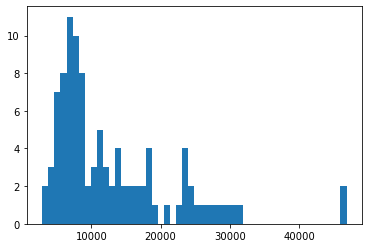

In [218]:
doc_lengths = [len(d['plainText']) for d in documents_by_id.values()]
plt.hist(doc_lengths, bins=50)
plt.show()

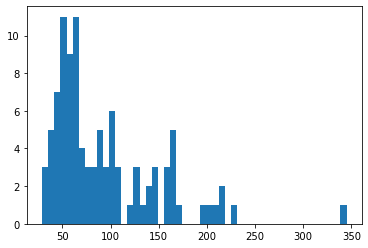

In [26]:
doc_num_annos = [len([a for a in annotations if a['document'] == doc_id])
                 for doc_id in documents_by_id]
plt.hist(doc_num_annos, bins=50)
plt.show()

## Phase 2 - Deciding on a Sentence Segmenter

### Step 2.1 (Standard segmentation analysis):
Apply the standard English sentence segmenter included with the library of your choice on the training set documents, report error metrics, and conduct an error analysis. Discuss your findings in the report and give three different examples of errors you observe.

In [25]:
def get_seg_positions(train_spans, id_list):
    '''
    return a list of dict containing doc id and each document's sentence start and end index
    '''
    seg_labels = []
    for doc_id in id_list:
        start = []
        end = []
        for a in train_spans:
            if a['document'] == doc_id:
                start.append(a['start'])
                end.append(a['end'])
        start.sort()
        end.sort()
        sd = {'document': doc_id,
              'start': start,
              'end': end,
             }
            
        seg_labels.append(sd) 
    return seg_labels

def make_seg_labels(documents_by_id, id_list, seg_positions):
    '''
    input: each document's sentence start and end index
    return: a list of dict containing doc id and a label sequence with start - 'S', end - 'E', others - 'I'
            for each charater in the document text
    '''
    seg_labels = []
    for i in range(len(seg_positions)):
        doc_id = seg_positions[i]['document']
        text = documents_by_id[doc_id]['plainText']
        length = len(text)
        label = ['I' for i in range(length)]
        # start - 'S', end - 'E', others - 'I'
        for j in seg_positions[i]['start']:
            label[j] = 'S'
        for k in seg_positions[i]['end']:
            label[k-1] = 'E'

        sd = {'document': doc_id,
              'label': label,
             }
        seg_labels.append(sd)
    return seg_labels

def get_label_sequence(seg_labels):
    '''
    merge labels of all documents given
    '''
    all_labels = []
    for i in range(len(seg_labels)):
        all_labels.extend(seg_labels[i]['label'])
    return all_labels

In [39]:
anno_seg_positions = get_seg_positions(train_spans, train_doc_id)
anno_seg_labels = make_seg_labels(documents_by_id, train_doc_id, anno_seg_positions)

In [31]:
# basic English pipeline provided by spacy
standard_segmenter = spacy.load("en_core_web_sm")

In [26]:
def get_standard_segmenter_results (documents_by_id, id_list, standard_segmenter):
    seg_results = []
    for doc_id in id_list:
        text = documents_by_id[doc_id]['plainText']
        
        #manually replace line break characters (i.e. \t, \r, and \n)
        text = text.replace('\r',' ')
        text = text.replace('\t',' ')
        text = text.replace('\n',' ')
        
    
        start = []
        end = []
        doc = standard_segmenter(text)
        for sent in doc.sents:
            start.append(sent.start_char)
            end.append(sent.end_char)

        start.sort()
        end.sort()
        sd = {'document': doc_id,
              'start': start,
              'end': end,}
        seg_results.append(sd)
    return seg_results

In [37]:
import prettytable as pt

def strict(anno_seg_labels, predicted_seg_labels, mode):
    TP, FP, FN = 0, 0, 0
    for i in range(len(anno_seg_labels)):
        if anno_seg_labels[i]==mode:
            if predicted_seg_labels[i]==mode:
                TP = TP + 1
            else:
                FN = FN + 1
    FP = predicted_seg_labels.count(mode) - TP
    return TP, FP, FN
    
def lenient(anno_seg_labels, predicted_seg_labels, mode):
    TP, FP, FN = 0, 0, 0
    for i in range(len(anno_seg_labels)):
        if anno_seg_labels[i]==mode:
            if mode in predicted_seg_labels[i-3:i+3]:
                TP = TP + 1
            else:
                FN = FN + 1
    FP = predicted_seg_labels.count(mode) - TP
    return TP, FP, FN

def error_metrics(anno_seg_labels, predicted_seg_labels, mode):
    table = pt.PrettyTable(['Label','Precision','Recall','F1-score'])
    for tag in ['S', 'E', 'I']:
        TP, FP, FN = mode(anno_seg_labels, predicted_seg_labels, tag)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F = (2*precision*recall) / (precision+recall)
        table.add_row([tag, precision, recall, F])
    print(table)


In [60]:
standard_seg_results = get_standard_segmenter_results (documents_by_id, train_doc_id, standard_segmenter)
standard_seg_labels = make_seg_labels(documents_by_id, train_doc_id, standard_seg_results)

Boundary Evaluation

In [61]:
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(standard_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(standard_seg_labels), lenient)

Error Metrics - strict:
+-------+---------------------+---------------------+---------------------+
| Label |      Precision      |        Recall       |       F1-score      |
+-------+---------------------+---------------------+---------------------+
|   S   | 0.16921881935197514 | 0.20491803278688525 | 0.18536526072687493 |
|   E   | 0.41832627118644067 |  0.5304231027535259 |  0.4677524429967427 |
|   I   |  0.9914575526261736 |  0.9879959493551875 |  0.9897237242216269 |
+-------+---------------------+---------------------+---------------------+
Error Metrics - lenient:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.6475810031069685 | 0.7841977962913196 | 0.7093715813783884 |
|   E   | 0.6701271186440678 | 0.8496977837474815 | 0.7493041160793603 |
|   I   | 1.0035016958114293 | 0.9999980412742686 | 1.

In [27]:
def count_seg_labels(seg_labels):
    count_s, count_e, count_i = 0, 0, 0
    for i in range(len(anno_seg_labels)):
        count_s = count_s + seg_labels[i]['label'].count('S')
        count_e = count_e + seg_labels[i]['label'].count('E')
        count_i = count_i + seg_labels[i]['label'].count('I')    
    print('[\'S\': ', count_s, ', \'E\': ', count_e, ', \'I\': ', count_i, ']')

In [63]:
count_seg_labels(anno_seg_labels)

['S':  7442 , 'E':  7445 , 'I':  1021072 ]


In [64]:
count_seg_labels(standard_seg_labels)

['S':  9012 , 'E':  9440 , 'I':  1017507 ]


Sentence Level Evaluation

In [28]:
def sentence_level_evaluation(train_spans, segmenter):
    total = len(train_spans)
    TP, FP, FN = 0, 0, 0
    
    for i in range(len(train_spans)):
        doc = segmenter(train_spans[i]['txt'])
        if len(list(doc.sents)) > 1:
            FN = FN + 1
            FP = FP + len(list(doc.sents))
        else:
            TP = TP + 1
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F = (2*precision*recall) / (precision+recall)
    table = pt.PrettyTable(['Precision','Recall','F1-score'])
    table.add_row([precision, recall, F])
    print(table)

In [301]:
def segmentation_errors(eval_spans, segmenter):
    for i in range(len(eval_spans)):
        doc = segmenter(eval_spans[i]['txt'])
        if len(list(doc.sents)) > 1:
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print("-----------------------------------------------------")
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('original text: \n'+eval_spans[i]['txt'])
            print('segmentation result: ', len(list(doc.sents)), 'sentences: ')
            i = 1
            for sent in doc.sents:
                print('[',i,'] ',sent)
                i = i+1
            print("-----------------------------------------------------")
        

In [67]:
sentence_level_evaluation(train_spans, standard_segmenter)

+--------------------+--------------------+--------------------+
|     Precision      |       Recall       |      F1-score      |
+--------------------+--------------------+--------------------+
| 0.5294401544401545 | 0.7363404483823331 | 0.6159806839238587 |
+--------------------+--------------------+--------------------+


In [303]:
standard_segmenter = spacy.load("en_core_web_sm")
segmentation_errors(random.sample(train_spans, 100), standard_segmenter)

-----------------------------------------------------
sentence # 0 / case 0826479.txt / @10077
original text: 
After the veteran's 
June 1998 right foot and right ankle injuries, subsequent 
SMRs, including a June 2000 health assessment report, were 
silent for any complaints, findings, treatment, or diagnosis 
relating to a right ankle disability.  
segmentation result:  2 sentences: 
[ 1 ]  After the veteran's 
June 1998 right foot and right ankle injuries, subsequent 
SMRs, including a June 2000 health assessment report, were 
silent for any complaints, findings, treatment, or diagnosis 
relating to a right ankle disability.
[ 2 ]   
-----------------------------------------------------
-----------------------------------------------------
sentence # 1 / case 1118746.txt / @844
original text: 
However, the RO denied his remaining claims for service connection for a sleep condition and a left shoulder condition.
segmentation result:  2 sentences: 
[ 1 ]  However, the RO denied his re

-----------------------------------------------------
sentence # 67 / case 1002616.txt / @27044
original text: 
The remaining lay evidence, the appellant's ex-wife's 
statement, does not address whether the appellant had 
symptoms of a psychiatric disability during service.  
segmentation result:  2 sentences: 
[ 1 ]  The remaining lay evidence, the appellant's ex-wife's 
statement, does not address whether the appellant had 
symptoms of a psychiatric disability during service.
[ 2 ]   
-----------------------------------------------------
-----------------------------------------------------
sentence # 70 / case 1623087.txt / @5699
original text: 
Given the extensive VA treatment records noting a diagnosis of PTSD, including notations of PTSD rendered by multiple VA psychologists, and after resolving any reasonable doubt in favor of the Veteran, the Board finds that the Veteran has a current diagnosis of PTSD.  
segmentation result:  2 sentences: 
[ 1 ]  Given the extensive VA treatme

### Step 2.2 (Improved segmentation analysis): 
Based on your error analysis, add some exceptions/extensions to the standard sentence splitter to prevent the most dominant instances of oversplitting. Apply the improved segmenter on the training data. In the report, explain your changes to the segmenter and report the metrics. A full error analysis is not necessary at this step because you know what you are fixing.

In [304]:
from spacy.language import Language

@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.is_space == True and doc[token.i - 1].is_punct == False:
            doc[token.i + 1].is_sent_start = False
        elif token.text == ';':
            doc[token.i + 1].is_sent_start = False
        
    return doc

improved_segmenter = spacy.load("en_core_web_sm")
improved_segmenter.add_pipe("set_custom_boundaries", before="parser")

<function __main__.set_custom_boundaries(doc)>

In [305]:
improved_segmenter.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
improved_segmenter.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])
improved_segmenter.tokenizer.add_special_case('Vet.App.', [{ORTH: 'Vet.App.'}])
improved_segmenter.tokenizer.add_special_case('Fed.Cir.', [{ORTH: 'Fed.Cir.'}])
improved_segmenter.tokenizer.add_special_case('I.  ', [{ORTH: 'I.  '}])
improved_segmenter.tokenizer.add_special_case('II.  ', [{ORTH: 'II.  '}])
improved_segmenter.tokenizer.add_special_case('III.  ', [{ORTH: 'III.  '}])
improved_segmenter.tokenizer.add_special_case('IV.  ', [{ORTH: 'IV.  '}])
improved_segmenter.tokenizer.add_special_case('V.  ', [{ORTH: 'V.  '}])
improved_segmenter.tokenizer.add_special_case('1.  ', [{ORTH: '1.  '}])
improved_segmenter.tokenizer.add_special_case('2.  ', [{ORTH: '2.  '}])
improved_segmenter.tokenizer.add_special_case('3.  ', [{ORTH: '3.  '}])
improved_segmenter.tokenizer.add_special_case('4.  ', [{ORTH: '4.  '}])
improved_segmenter.tokenizer.add_special_case('5.  ', [{ORTH: '5.  '}])

In [50]:
improved_seg_results = get_standard_segmenter_results (documents_by_id, train_doc_id, improved_segmenter)
improved_seg_labels = make_seg_labels(documents_by_id, train_doc_id, improved_seg_results)

In [51]:
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(improved_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(improved_seg_labels), lenient)
print('Error Metrics - sentence level:')
sentence_level_evaluation(train_spans, improved_segmenter)

Error Metrics - strict:
+-------+---------------------+---------------------+---------------------+
| Label |      Precision      |        Recall       |       F1-score      |
+-------+---------------------+---------------------+---------------------+
|   S   | 0.17898339460007606 | 0.18784089397365972 | 0.18330520576398804 |
|   E   |  0.4778124250419765 |  0.5297872340425532 |  0.5024593265228907 |
|   I   |  0.9914041358970697 |  0.9902668823369507 |  0.990835182789974  |
+-------+---------------------+---------------------+---------------------+
Error Metrics - lenient:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.7330460134364305 | 0.7693228681654916 | 0.7507464624172401 |
|   E   | 0.7705684816502758 | 0.8543882978723404 | 0.810316559465254  |
|   I   | 1.0011465012410778 | 0.9999980720773174 | 1.

In [52]:
count_seg_labels(anno_seg_labels)
count_seg_labels(improved_seg_labels)

['S':  7517 , 'E':  7520 , 'I':  1037386 ]
['S':  7889 , 'E':  8338 , 'I':  1036196 ]


In [307]:
segmentation_errors(random.sample(train_spans, 50), improved_segmenter)

-----------------------------------------------------
sentence # 5 / case 0626988.txt / @23730
original text: 
See Espiritu v. Derwinski, 2 
Vet. App. 492, 495 (1992).  See also Routen v. Brown, 10 Vet. 
App. 183, 186 (1997) ("a layperson is generally not capable 
of opining on matters requiring medical knowledge"), aff'd 
sub nom. Routen v. West, 142 F.3d 1434 (Fed. Cir. 1998), 
cert. denied, 119 S. Ct. 404 (1998).
segmentation result:  5 sentences: 
[ 1 ]  See Espiritu v. Derwinski, 2 
Vet. App. 492, 495 (1992).
[ 2 ]   See also Routen v. Brown, 10 Vet.
[ 3 ]  
App. 183, 186 (1997) ("a layperson is generally not capable 
of opining on matters requiring medical knowledge"), aff'd 
sub nom.
[ 4 ]  Routen v. West, 142 F.3d 1434 (Fed. Cir. 1998), 
cert.
[ 5 ]  denied, 119 S. Ct. 404 (1998).
-----------------------------------------------------
-----------------------------------------------------
sentence # 7 / case 1634413.txt / @4298
original text: 
The Veteran has not asserted that hi

### Step 2.3 (Law-specific sentence segmenter): 
Download Savelka's law-specific sentence segmenter (https://github.com/jsavelka/luima_sbd). The details of its development can be found the corresponding paper.3 You can call it using the command line or directly via Python. It will either return segmented sentences or sentence offset integers. Apply the segmenter to the training data4, report error metrics, and conduct an error analysis. Discuss your findings in the report and give at least three different examples of errors you observe. How are those errors different from the ones by the non-legal segmenters?

In [54]:
def get_luima_results(documents_by_id, id_list, segmenter):
    seg_results = []
    for doc_id in id_list:
        text = documents_by_id[doc_id]['plainText']
        
        #manually replace line break characters (i.e. \t, \r and \n)
        #replace with space to not change the offset, but might affect the segmentation?
        text = text.replace('\r',' ')
        text = text.replace('\t',' ')
        text = text.replace('\n',' ')
        
        start = []
        end = []
        indices = segmenter(text, offsets=True)
        for i in range(len(indices)):
            start.append(indices[i][0])
            end.append(indices[i][1])

        start.sort()
        end.sort()
        sd = {'document': doc_id,
              'start': start,
              'end': end,}
        seg_results.append(sd)
    return seg_results

In [55]:
def luima_sentence_level_evaluation(train_spans, segmenter):
    total = len(train_spans)
    TP, FP, FN = 0, 0, 0
    
    for i in range(len(train_spans)):
        doc = segmenter(train_spans[i]['txt'], offsets=False)
        if len(doc) > 1:
            FN = FN + 1
            FP = FP + len(doc)
        else:
            TP = TP + 1
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F = (2*precision*recall) / (precision+recall)
    table = pt.PrettyTable(['Precision','Recall','F1-score'])
    table.add_row([precision, recall, F])
    print(table)

In [56]:
from luima_sbd.sbd_utils import text2sentences
luima_segmenter = text2sentences

luima_seg_results = get_luima_results (documents_by_id, train_doc_id, luima_segmenter)
luima_seg_labels = make_seg_labels(documents_by_id, train_doc_id, luima_seg_results)
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(luima_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(luima_seg_labels), lenient)
print('Error Metrics - sentence level:')
luima_sentence_level_evaluation(train_spans, luima_segmenter)

Error Metrics - strict:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.8526740665993946 | 0.8992949314886258 | 0.8753641955325349 |
|   E   | 0.5602926337033299 | 0.5906914893617021 | 0.5750906266183324 |
|   I   | 0.9963012521139493 | 0.9955146878789572 | 0.9959078146901111 |
+-------+--------------------+--------------------+--------------------+
Error Metrics - lenient:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.8985872855701312 | 0.9477185047226288 | 0.9224991906765945 |
|   E   | 0.8872351160443996 | 0.935372340425532  | 0.910668047643708  |
|   I   | 1.000788178670554  | 0.9999980720773174 | 1.0003929693681584 |
+-

In [308]:
def luima_seg_errors(eval_spans, segmenter):
    for i in range(len(eval_spans)):
        doc = segmenter(eval_spans[i]['txt'], offsets=False)
        if len(doc) > 1:
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print("-----------------------------------------------------")
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('original text: \n'+eval_spans[i]['txt'])
            print('segmentation result: ', len(doc), 'sentences')
            for i in range(len(doc)):
                print('[',i+1,'] ', doc[i])
            print("-----------------------------------------------------")

In [313]:
luima_seg_errors(random.sample(train_spans, 100), luima_segmenter)

-----------------------------------------------------
sentence # 1 / case 1018283.txt / @2288
original text: 
38 U.S.C.A. � 1110 (West 2002); 
38 C.F.R. �� 3.303, 3.304 (2009).
segmentation result:  2 sentences
[ 1 ]  38 U.S.C.A. � 1110 (West 2002);
[ 2 ]  38 C.F.R. �� 3.303, 3.304 (2009).
-----------------------------------------------------
-----------------------------------------------------
sentence # 2 / case 0829439.txt / @0
original text: 
Citation Nr: 0829439	
Decision Date: 08/28/08    Archive Date: 09/04/08

DOCKET NO.  03-20 425	)	DATE
	)
	)
segmentation result:  6 sentences
[ 1 ]  Citation Nr: 0829439
[ 2 ]  Decision Date: 08/28/08
[ 3 ]  Archive Date: 09/04/08
[ 4 ]  DOCKET NO.  03-20 425
[ 5 ]  DATE
[ 6 ]  )
-----------------------------------------------------
-----------------------------------------------------
sentence # 7 / case 0734568.txt / @11759
original text: 
The dose data is then forwarded to the 
Under Secretary for Benefits for consideration.
segmentation r

## Phase 3: Preprocessing

### Step 3.1 (splitting unlabeled data): 
Sentence-segment all decisions in the unlabeled corpus. Produce a histogram for the number of sentences across all unlabeled decisions and report the total number of sentences. For the unlabeled corpus, this should result in a total of ~3M sentences. If you are an order of magnitude below or above that, check for errors and request help if needed.

In [48]:
def merge_text(dir_path, fpath): 
    doc_list = []
    
    for file in file_names:
        f = open(dir_path+"/"+file,'r+',encoding='latin-1')
        plainText = f.read()
        doc_id = file.strip('.txt')
        x =  { "_id": doc_id,
                "name": file,
                "plainText":plainText}
        doc_list.append(x)
        
    with open(fpath, 'w') as file:
        json_str = json.dumps(doc_list)
        file.write(json_str)
        file.close()

In [61]:
#merge unlabeled data
unlabeled_corpus_fpath = './data/unlabeled_corpus.json'
unlabeled_corpus_dir = './data/unlabeled'
unlabeled_doc_names = os.listdir(unlabeled_corpus_dir)
#merge_text(unlabeled_corpus_dir, unlabeled_corpus_fpath)

In [50]:
#load unlabeled data
unlabeled_data = json.load(open(unlabeled_corpus_fpath))
print(len(unlabeled_data))

30000


In [70]:
unlabeled_data[0]

{'_id': '0617618',
 'name': '0617618.txt',
 'plainText': 'Citation Nr: 0617618\t\nDecision Date: 06/16/06    Archive Date: 06/27/06\n\nDOCKET NO.  04-24 710A\t)\tDATE\n\t)\n\t)\n\nOn appeal from the\nDepartment of Veterans Affairs Regional Office in St. \nPetersburg, Florida\n\n\nTHE ISSUE\n\nEntitlement to service connection for post-traumatic stress \ndisorder.\n\n\nREPRESENTATION\n\nAppellant represented by:\tDisabled American Veterans\n\n\nATTORNEY FOR THE BOARD\n\nDavid S. Ames, Associate Counsel\n\n\nINTRODUCTION\n\nThe veteran served on active duty from May 1954 to March \n1957.\n\nThis matter comes properly before the Board of Veterans\' \nAppeals (Board) on appeal from a September 2002 rating \ndecision the Department of Veterans Affairs (VA) Regional \noffice in St. Petersburg, Florida (RO).\n\n\nFINDING OF FACT\n\nThe veteran\'s alleged in-service stressors have not been \nverified by official records or any other supportive \nevidence.\n\n\nCONCLUSION OF LAW\n\nPTSD was not

In [37]:
def seg_unlabeled_data(documents, segmenter):
    seg_results = []
    for i in range(len(documents)):
        text = documents[i]['plainText']
        doc_id = documents[i]['_id']
        
        #manually replace line break characters (i.e. \t, \r and \n)
        #replace with space to not change the offset, but might affect the segmentation?
        text = text.replace('\r',' ')
        text = text.replace('\t',' ')
        text = text.replace('\n',' ')
        
        start = []
        end = []
        indices = segmenter(text, offsets=True)
        for j in range(len(indices)):
            start = indices[j][0]
            end = indices[j][1]
            txt = text[start:end]
            sent = {'document': doc_id,
                    'txt': txt,
                    'start': start,
                    'end': end,}
            seg_results.append(sent)
    return seg_results

seg by luima simple_model

In [331]:
sents_of_unlabeled = seg_unlabeled_data(unlabeled_data, luima_segmenter)

Total number of sentences

In [332]:
len(sents_of_unlabeled)

2786737

Store the segmented sentences in './data/sentences_of_unlabeled_data.json'

In [333]:
with open('./data/sentences_of_unlabeled_data.json', 'w') as file:
    json_str = json.dumps(sents_of_unlabeled)
    file.write(json_str)
    file.close()

Load segmented sentences in './data/sentences_of_unlabeled_data.json'

In [39]:
sents_of_unlabeled = json.load(open('./data/sentences_of_unlabeled_data.json'))
len(sents_of_unlabeled)

2786737

In [40]:
random.choice(sents_of_unlabeled)

{'document': '1233268',
 'txt': 'Records of VA outpatient primary care from 2002 to 2006 are silent for any symptoms or diagnoses of heart related disorders.',
 'start': 11427,
 'end': 11551}

Histogram for the document length across the unlabeled corpus

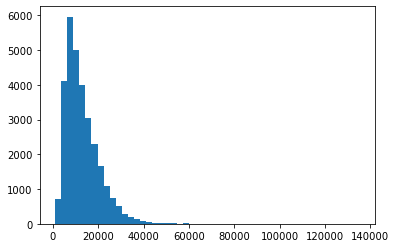

In [57]:
doc_lengths = [len(d['plainText']) for d in unlabeled_data]
plt.hist(doc_lengths, bins=50)
plt.show()

Histogram for the number of sentences across all unlabeled decisions

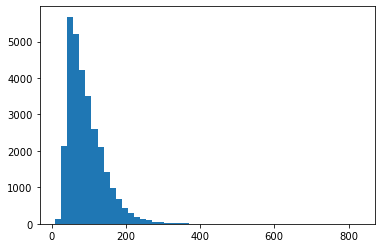

In [62]:
num_sents_unlabeled = [len([a for a in sents_of_unlabeled if a['document'] == doc_name.strip('.txt')])
                       for doc_name in unlabeled_doc_names]
plt.hist(num_sents_unlabeled, bins=50)
plt.show()

### Step 3.2 (sentence-wise preprocessing): 
Write a tokenizer function that splits a sentence into tokens and applies basic preprocessing to reduce uninformative noise.

At the very least, it should do the following:
+ treat punctuation consistently
+ simplify numbers
+ lowercase everything
+ optionally deal with other anomalies you encounter


In [198]:
standard_segmenter = spacy.load("en_core_web_sm")
standard_segmenter.disable_pipes('parser')

standard_segmenter.tokenizer.add_special_case('Vet.App.', [{ORTH: 'Vet.App.'}])
standard_segmenter.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
standard_segmenter.tokenizer.add_special_case('Fed. Cir.', [{ORTH: 'Fed. Cir.'}])
standard_segmenter.tokenizer.add_special_case('Fed.Cir.', [{ORTH: 'Fed.Cir.'}])
standard_segmenter.tokenizer.add_special_case("service'-", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "-"}])
standard_segmenter.tokenizer.add_special_case("service'-the", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "-"}, {ORTH: "the"}])
standard_segmenter.tokenizer.add_special_case("service'--the", [{ORTH: "service"}, {ORTH: "'"}, {ORTH: "--"}, {ORTH: "the"}])
standard_segmenter.tokenizer.add_special_case('service"-', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '-'}])
standard_segmenter.tokenizer.add_special_case('service"-the', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '-'}, {ORTH: 'the'}])
standard_segmenter.tokenizer.add_special_case('service"--the', [{ORTH: 'service'}, {ORTH: '"'}, {ORTH: '--'}, {ORTH: 'the'}])

# Modify tokenizer infix patterns to not seperate on '-'
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        r"(?<=[{a}])(?:{h})(?=[{a}])".format(a=ALPHA, h=HYPHENS),
        r"(?<=[{a}0-9])[:<>=/](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
standard_segmenter.tokenizer.infix_finditer = infix_re.finditer

In [38]:
standard_segmenter.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f83f1e067c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f840ba584a0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f83f1e31680>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f83f120fc80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f83f12fb880>)]

Tokenization by multiprocessing

In [41]:
def spacy_tokenize_multi(sents):
    docs = list(standard_segmenter.pipe(sents, n_process=4))
    tokens_spacy = []
    for i in range(len(docs)):
        clean_tokens = []
        for t in docs[i]:
            #remove punctuation
            if t.pos_ == 'PUNCT':
                pass
            #remove space, i.e., \r', '\t', '\n'
            elif t.pos_ == 'SPACE':
                pass
            elif t.pos_ == 'SYM':
                pass
            #elif t.text == '�':
                #pass
            #'three'-NUM5
            elif t.pos_ == 'NUM' and t.is_digit == True:
                clean_tokens.append(f'<NUM{len(t)}>')
            else:
                clean_tokens.append(t.lemma_.lower())
        tokens_spacy.append(clean_tokens)
    return tokens_spacy

def spans_add_spacy_tokens_multi(spans):
    sents = [s['txt'] for s in spans]
    tokens_spacy = spacy_tokenize_multi(sents)
    for i in range(len(spans)):
        spans[i]['tokens_spacy'] = tokens_spacy[i]

Tokenization by a single process

In [42]:
def spacy_tokenize(txt):
    doc = standard_segmenter(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        #remove punctuation
        if t.pos_ == 'PUNCT':
            pass
        #remove space, i.e., \r', '\t', '\n'
        elif t.pos_ == 'SPACE':
            pass
        #'three'-NUM5
        elif t.pos_ == 'NUM' and t.is_digit == True:
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_.lower())
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [43]:
spans_add_spacy_tokens_multi(train_spans)
spans_add_spacy_tokens_multi(val_spans)
spans_add_spacy_tokens_multi(test_spans)

In [130]:
train_spans[0]

{'txt': 'Citation Nr: 0634451\t\r\nDecision Date: 11/07/06    Archive Date: 11/16/06\r\n\r\nDOCKET NO.  03-11 289\t)\tDATE\r\n\t)\r\n\t)',
 'document': '60b60661f8611168dd279c99',
 'type': 'CaseHeader',
 'start': 0,
 'start_normalized': 0.0,
 'end': 112,
 'tokens_spacy': ['citation',
  'nr',
  '<NUM7>',
  'decision',
  'date',
  '11/07/06',
  'archive',
  'date',
  '11/16/06',
  'docket',
  'no',
  '<NUM2>',
  '<NUM2>',
  '<NUM3>',
  'date']}

In [112]:
random.choice(train_spans)

{'txt': 'On VA examination in January 2001, the Veteran reported an injury \r\nto his left shoulder while practicing rappelling. ',
 'document': '60b606ccf8611168dd279ce8',
 'type': 'Evidence',
 'start': 12212,
 'start_normalized': 0.5863542516925145,
 'end': 12330,
 'tokens_spacy': ['on',
  'va',
  'examination',
  'in',
  'january',
  '<NUM4>',
  'the',
  'veteran',
  'report',
  'an',
  'injury',
  'to',
  'his',
  'left',
  'shoulder',
  'while',
  'practice',
  'rappelling']}

### Step 3.3 (Tokenize unlabeled data): 
Use your tokenizer to process all sentences in the segmented, unlabeled data. Produce a histogram of number of tokens in each sentence for the unlabeled data and include it in the report. Then assemble a single file, each line of which consists of a sentence's tokens, separated by a single whitespace.The sentences in the file should be in random order. In producing the file, you can discard sentences below a minimum length (e.g. 5 tokens).

In [132]:
sents_of_unlabeled = json.load(open('./data/sentences_of_unlabeled_data.json'))

In [134]:
len(sents_of_unlabeled)

2786737

Use the multiprocessing tokenizer to process all sentences in the segmented, unlabeled data

In [135]:
spans_add_spacy_tokens_multi(sents_of_unlabeled)

In [56]:
random.choice(sents_of_unlabeled)

{'document': '1601494',
 'txt': 'In the December 2013 Memorandum Decision, the Court vacated the portion of the October 2012 Board opinion denying service connection for a cervical spine disability and remanded the matter to the Board for action consistent with the Memorandum Decision.',
 'start': 2422,
 'end': 2675,
 'tokens_spacy': ['in',
  'the',
  'december',
  '<NUM4>',
  'memorandum',
  'decision',
  'the',
  'court',
  'vacate',
  'the',
  'portion',
  'of',
  'the',
  'october',
  '<NUM4>',
  'board',
  'opinion',
  'deny',
  'service',
  'connection',
  'for',
  'a',
  'cervical',
  'spine',
  'disability',
  'and',
  'remand',
  'the',
  'matter',
  'to',
  'the',
  'board',
  'for',
  'action',
  'consistent',
  'with',
  'the',
  'memorandum',
  'decision']}

Histogram of number of tokens in each sentence for the unlabeled data

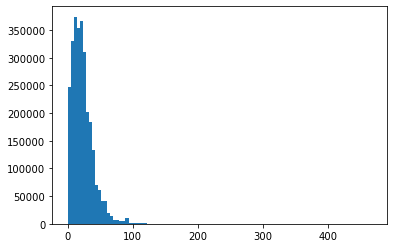

In [57]:
num_tokens = [len(s['tokens_spacy']) for s in sents_of_unlabeled]
plt.hist(num_tokens, bins=100)
plt.show()

In [51]:
sents_of_unlabeled[0]

{'document': '0617618',
 'txt': 'Citation Nr: 0617618',
 'start': 0,
 'end': 20,
 'tokens_spacy': ['citation', 'nr', '<NUM7>']}

In [52]:
random.shuffle(sents_of_unlabeled)
sents_of_unlabeled[0]

{'document': '1308097',
 'txt': 'Unlike the claim for allergic rhinitis and sinusitis, the claim for sleep apnea has not been certified to the Board as on appeal nor has it otherwise been developed for appellate review.',
 'start': 4187,
 'end': 4373,
 'tokens_spacy': ['unlike',
  'claim',
  'allergic',
  'rhinitis',
  'sinusitis',
  'claim',
  'sleep',
  'apnea',
  'certify',
  'board',
  'appeal',
  'develop',
  'appellate',
  'review']}

Assemble a single file, each line of which consists of a sentence's tokens, separated by a single whitespace.

In [137]:
count = 0
with open('./data/tokens_of_unlabeled.txt','w+') as file:
    for sent in sents_of_unlabeled:
        tokens = sent['tokens_spacy']
        if len(tokens) >= 5:
            count = count + len(tokens)
            for i in range(len(tokens)):
                file.write(tokens[i]+' ')
            file.write('\n')
print(count)

62632749


## Phase 4: Developing Word Embeddings

### Step 4.1 (Custom FastText embeddings): 
Train a word embedding model on the compiled, tokenized, unannotated data to obtain a qualified word vector representation. I use FastText for this. 

The goal is to produce a 100-dimensional vector model with standard character n-gram parameters and a reasonable minimum word occurrence count (e.g., n >= 20).

In [148]:
model_skipgram = fasttext.train_unsupervised('./data/tokens_of_unlabeled.txt', "skipgram", #"cbow", "skipgram"
                                    minCount=20, wordNgrams=4, epoch=30, dim=100, thread=4)

In [149]:
model_skipgram.save_model("./model/fasttext_skipgram.bin")

In [150]:
len(model_skipgram.words)

14245

### Step 4.2 (Evaluating Custom Embeddings Manually): 
Load the embeddings via Python, determine the vocabulary size and include it in the report. To convince yourself that the embeddings capture the token distribution in the corpus, you should explore nearest neighbors for at least the following strings:

+ "veteran"
+ "vet"
+ "service"
+ "cause"
+ "caused"
+ "remanded"
+ "vietnam"
+ "see"
... 

as well as three more strings of your choice after trying several of them. It is recommended to open a BVA decision and pick terms that appear interesting

Load the embeddings

In [44]:
fasttext.FastText.eprint = lambda x: None
model_cbow = fasttext.load_model("/Users/xiuxiu/Desktop/LDSI/Project/code/model/fasttext_cbow.bin")
model_skipgram = fasttext.load_model("/Users/xiuxiu/Desktop/LDSI/Project/code/model/fasttext_unlabeled.bin")

Determine the vocabulary size

In [163]:
len(model_cbow.words)

14216

In [165]:
len(model_skipgram.words)

14216

Explore nearest neighbors

In [45]:
word_list = ['veteran', 'vet', 'service', 'cause', 'caused', 'remanded', 'vietnam', 'see',
             'ptsd', 'grant', 'deny']
def find_nearest_neighbors(model, word_list):
    df = pd.DataFrame(columns=word_list)
    #df.columns = word_list
    for word in word_list:
        nns = model.get_nearest_neighbors(word)
        p, t = [],[]
        for i in range(len(nns)):
            p.append(nns[i][0])
            t.append(nns[i][1])
        df[word] = t
    return df

In [46]:
nearest_neighbors = find_nearest_neighbors(model_cbow, word_list)
nearest_neighbors

,veteran,vet,service,cause,caused,remanded,vietnam,see,ptsd,grant,deny
0,the,rivet,inservice,cause(s,cause,handed,korea,<NUM3>,mdd,granting,unappealed
1,additionally,vet.,disability,contribute,cause(s,remands,republic,v.,stressor,connection,reopen
2,furthermore,mc,postservice,exacerbate,contribute,remandable,rvn,<NUM1>,stressors,connection-,entitlement
3,his,vet.app.,military,contributor,contributor,remand,korean,<NUM2>,psychiatric,award,denial
4,veterans,app.,nonmilitary,attributable,exacerbate,management,country,quote,stressor(s,warrant,reopening
5,'s,<NUM3>,connection,contributing,attributable,amc,thailand,id.,pstd,connective,grant
6,moreover,9h,current,relate,related,advance,vietnamese,robinette,dysthymic,deny,petition
7,that,brooke,active,contributory,interrelate,return,guam,<NUM4>,depression,entitlement,readjudicate
8,addition,"52,744",condition,contribution,contributing,via,panama,vet.,schizoaffective,establish,den
9,appellant,v.,disability-,interrelate,causative,rounded,overseas,app.,dysthymia,establishment,decision


In [47]:
nearest_neighbors = find_nearest_neighbors(model_skipgram, word_list)
nearest_neighbors

,veteran,vet,service,cause,caused,remanded,vietnam,see,ptsd,grant,deny
0,the,app,connection,exacerbate,cause,management,republic,v.,depressive,connection,petition
1,'s,v.,active,contributor,contributor,accordingly,rvn,vet,pstd,entitlement,unappealed
2,his,vet.,disease,attributable,confused,via,era,id.,mdd,incur,entitlement
3,appellant,app.,disability,contribute,exacerbate,handed,country,<NUM4>,bipolar,connection-,reopen
4,he,see,military,permanently,probably,hereby,korea,cf,anxiety,laws,reopening
5,additionally,.app,incur,precipitate,definitely,amc,nam,vet.,dysthymic,warrant,alia
6,have,.,injury,accelerate,multifactorial,action,korean,also,psychiatric,establishment,disallowed
7,sopko,supra,connect,due,seem,please,thailand,app.,depression,deny,connection
8,sauter,app.112,aggravate,contributory,think,advance,danang,app,dysthymia,proximately,decline
9,that,brown,during,causative,somehow,center,inland,<NUM3>,mst,granting,inter


## Phase 5: Training Classifiers

### Step 5.1 (TFIDF featurization): 
Based on the classifier workshop code, produce a TFIDF featurization of your training, dev, and test data. Document your work briefly in the report.


In [48]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

In [49]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,4))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [64]:
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
dfs = top_features_by_class(train_tfidf_spacy, train_spans_labels, tfidf_features_spacy)

In [129]:
dfs.keys()

dict_keys(['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBased/Intermediate Finding', 'EvidenceBasedReasoning', 'Header', 'LegalPolicy', 'LegalRule', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions'])

In [65]:
dfs['Citation']

,feature,tfidf
0,�,0.101528
1,<NUM2>,0.093349
2,<NUM3>,0.070686
3,<NUM4>,0.067326
4,v.,0.047998
5,c.f.r �,0.045567
6,c.f.r,0.045500
7,<NUM2> c.f.r �,0.045301
8,<NUM2> c.f.r,0.045234
9,app,0.043677


In [131]:
dfs['EvidenceBasedReasoning']

,feature,tfidf
0,the,0.028284
1,his,0.008249
2,of,0.006280
3,in,0.006146
4,opinion,0.005899
5,be,0.005887
6,this,0.005529
7,as,0.005334
8,competent to,0.005290
9,in this,0.005282


In [50]:
def make_tfidf_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)), axis=1)
    return X, y

In [51]:
tfidf_train_X, tfidf_train_y = make_tfidf_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
tfidf_test_X, tfidf_test_y = make_tfidf_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)
tfidf_dev_X, tfidf_dev_y = make_tfidf_feature_vectors_and_labels(val_spans, spacy_tfidf_vectorizer)

In [53]:
print(f'{tfidf_train_X.shape} {tfidf_train_y.shape}')
print(f'{tfidf_dev_X.shape} {tfidf_dev_y.shape}')
print(f'{tfidf_test_X.shape} {tfidf_test_y.shape}')

(7602, 26840) (7602,)
(816, 26840) (816,)
(822, 26840) (822,)


### Step 5.2 (Word Embedding Featurization): 
Using the embeddings, you should now extend the code provided by the classifier workshop by leveraging the trained embeddings to featurize sentences. For each sentence, the feature vector should contain:

+ an average of the embedding vectors for the tokens in the sentence (with the same dimension as the embedding model)
+ a single float variable with the [0-1] normalized position of the sentence in the document as in the workshop
+ a single float variable representing the number of tokens in the sentence, normalized by subtracting the mean and dividing by the standard deviation across all sentence tokens counts in the training data

In [284]:
def get_average_word_emdedding(spans, model):
    embedding_list = []
    for s in spans:
        tokens = s['tokens_spacy']
        embedding = 0
        for t in tokens:
            embedding = embedding + model.get_word_vector(t)
        embedding_list.append(embedding/len(tokens))
    return np.array(embedding_list)

In [285]:
def make_embedding_feature_vectors_and_labels(spans, model):
    sentence_embedding = get_average_word_emdedding(spans, model)
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    mean = np.mean(num_tokens)
    std = np.std(num_tokens)
    num_tokens_normalized = np.array([ (n-mean)/std for n in num_tokens ])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((sentence_embedding, np.expand_dims(starts_normalized, axis=1), 
                        np.expand_dims(num_tokens_normalized, axis=1)), axis=1)
    return X, y

In [70]:
model = model_skipgram
embedding_train_X, embedding_train_y = make_embedding_feature_vectors_and_labels(train_spans, model)
embedding_dev_X, embedding_dev_y = make_embedding_feature_vectors_and_labels(val_spans, model)
embedding_test_X, embedding_test_y = make_embedding_feature_vectors_and_labels(test_spans, model)

In [71]:
print(f'{embedding_train_X.shape} {embedding_train_y.shape}')
print(f'{embedding_dev_X.shape} {embedding_dev_y.shape}')
print(f'{embedding_test_X.shape} {embedding_test_y.shape}')

(7602, 102) (7602,)
(816, 102) (816,)
(822, 102) (822,)


In [159]:
embedding_train_X[0]

array([-2.06298041e+00,  9.63091195e-01, -1.12075937e+00,  9.85574484e-01,
        1.25130534e-01, -1.43172288e+00,  5.45264542e-01, -1.18455887e+00,
       -6.59598932e-02, -1.93086708e+00, -1.35700226e-01, -1.53642505e-01,
       -1.18226218e+00, -3.76940995e-01, -1.81380975e+00,  1.34765458e+00,
       -9.83381987e-01,  1.69645101e-01, -2.95935184e-01,  4.27126288e-01,
       -1.41668841e-01,  4.60748464e-01,  4.85618144e-01,  5.29705942e-01,
        3.30387801e-01, -1.11286867e+00,  1.62706003e-01,  5.40245175e-01,
       -8.42252076e-02,  1.15445530e+00,  1.15304172e+00,  6.92377865e-01,
        9.58558202e-01,  6.05313122e-01,  3.57195407e-01, -4.06738251e-01,
       -2.04712915e+00,  5.95224559e-01, -1.81138587e+00, -4.97384146e-02,
       -8.71052146e-01, -2.62442446e+00, -1.08198965e+00,  1.16010940e+00,
       -1.23870587e+00,  4.79798228e-01, -2.58410769e-03,  1.72990716e+00,
        4.72757310e-01, -9.54800993e-02,  7.78484106e-01,  2.52389424e-02,
       -1.91200221e+00, -

### Step 5.3 (Model Training): 
Once you have featurized the data, go on and train and evaluate several classifiers using the `classification_report` and `confusion_matrix` functions provided during the workshop on TFIDF and embedding featurizations. You should train and evaluate at least the following models on the training data and evaluate them on the dev data, respectively:

### Train with TFIDF feautures

In [152]:
tfidf_clf_nb = GaussianNB()
tfidf_clf_nb = tfidf_clf_nb.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF GaussianNB TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_nb.predict(tfidf_train_X)))
print('TFIDF GaussianNB DEV:\n'+classification_report(val_spans_labels, tfidf_clf_nb.predict(tfidf_dev_X)))
print('TFIDF GaussianNB TEST:\n'+classification_report(test_spans_labels, tfidf_clf_nb.predict(tfidf_test_X)))

TFIDF GaussianNB TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.42      0.99      0.59        88
                        CaseHeader       0.33      1.00      0.50        82
                         CaseIssue       0.99      1.00      0.99        77
                          Citation       0.99      0.93      0.96      1019
                   ConclusionOfLaw       0.79      0.90      0.84       169
                          Evidence       1.00      0.94      0.97      2067
EvidenceBased/Intermediate Finding       0.94      0.95      0.94       682
            EvidenceBasedReasoning       0.87      0.97      0.92       526
                            Header       0.93      0.68      0.78       718
                       LegalPolicy       0.61      1.00      0.76        98
                         LegalRule       0.99      0.93      0.96       849
              PolicyBasedReasoning       0.53      1.00      0.

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TFIDF GaussianNB DEV:
                                    precision    recall  f1-score   support

                        CaseFooter       0.43      1.00      0.60         9
                        CaseHeader       0.28      1.00      0.44         9
                         CaseIssue       1.00      0.56      0.71         9
                          Citation       1.00      0.86      0.93       102
                   ConclusionOfLaw       0.61      0.65      0.63        17
                          Evidence       0.73      0.86      0.79       244
EvidenceBased/Intermediate Finding       0.47      0.57      0.52        54
            EvidenceBasedReasoning       0.36      0.20      0.26        86
                            Header       0.91      0.62      0.74        79
                       LegalPolicy       0.17      1.00      0.29         2
                         LegalRule       0.78      0.88      0.83        73
              PolicyBasedReasoning       0.00      0.00      0.00

In [64]:
tfidf_clf_lr = LogisticRegression(max_iter=150)
tfidf_clf_lr = tfidf_clf_lr.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF LogisticRegression TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_lr.predict(tfidf_train_X)))
print('TFIDF LogisticRegression DEV:\n'+classification_report(val_spans_labels, tfidf_clf_lr.predict(tfidf_dev_X)))
print('TFIDF LogisticRegression TEST:\n'+classification_report(test_spans_labels, tfidf_clf_lr.predict(tfidf_test_X)))

TFIDF LogisticRegression TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.97      0.95      0.96        88
                        CaseHeader       0.98      0.96      0.97        82
                         CaseIssue       0.91      0.92      0.92        77
                          Citation       0.97      0.99      0.98      1019
                   ConclusionOfLaw       0.88      0.77      0.82       169
                          Evidence       0.82      0.98      0.89      2067
EvidenceBased/Intermediate Finding       0.83      0.73      0.77       682
            EvidenceBasedReasoning       0.88      0.50      0.64       526
                            Header       0.98      0.97      0.98       718
                       LegalPolicy       0.81      0.17      0.29        98
                         LegalRule       0.85      0.91      0.88       849
              PolicyBasedReasoning       0.00      0.00

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/

retrain on train and dev set

In [257]:
tfidf_train_dev_X = np.append(tfidf_train_X, tfidf_dev_X, axis=0)
tfidf_train_dev_y = np.append(tfidf_train_y, tfidf_dev_y, axis=0)
print(tfidf_train_dev_X.shape)

(8418, 26840)


In [258]:
tfidf_clf_lr = LogisticRegression(max_iter=150)
tfidf_clf_lr = tfidf_clf_lr.fit(tfidf_train_dev_X, tfidf_train_dev_y)
print('TFIDF LogisticRegression TRAIN:\n'+classification_report(tfidf_train_dev_y, tfidf_clf_lr.predict(tfidf_train_dev_X)))
print('TFIDF LogisticRegression TEST:\n'+classification_report(test_spans_labels, tfidf_clf_lr.predict(tfidf_test_X)))

TFIDF LogisticRegression TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.97      0.96      0.96        97
                        CaseHeader       0.98      0.97      0.97        91
                         CaseIssue       0.92      0.93      0.92        86
                          Citation       0.97      0.99      0.98      1121
                   ConclusionOfLaw       0.88      0.78      0.83       186
                          Evidence       0.82      0.98      0.89      2311
EvidenceBased/Intermediate Finding       0.84      0.72      0.78       736
            EvidenceBasedReasoning       0.85      0.52      0.65       612
                            Header       0.99      0.97      0.98       797
                       LegalPolicy       0.79      0.19      0.31       100
                         LegalRule       0.86      0.92      0.89       922
              PolicyBasedReasoning       0.00      0.00

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/

In [153]:
tfidf_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
tfidf_clf_rf = tfidf_clf_rf.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF RandomForest TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_rf.predict(tfidf_train_X)))
print('TFIDF RandomForest DEV:\n'+classification_report(val_spans_labels, tfidf_clf_rf.predict(tfidf_dev_X)))
print('TFIDF RandomForest TEST:\n'+classification_report(test_spans_labels, tfidf_clf_rf.predict(tfidf_test_X)))

TFIDF RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.92      0.96        88
                        CaseHeader       0.98      0.98      0.98        82
                         CaseIssue       0.95      0.79      0.87        77
                          Citation       0.98      0.94      0.96      1019
                   ConclusionOfLaw       1.00      0.01      0.02       169
                          Evidence       0.41      1.00      0.58      2067
EvidenceBased/Intermediate Finding       0.88      0.20      0.32       682
            EvidenceBasedReasoning       1.00      0.02      0.03       526
                            Header       1.00      0.50      0.67       718
                       LegalPolicy       1.00      0.07      0.13        98
                         LegalRule       0.95      0.51      0.67       849
              PolicyBasedReasoning       0.00      0.00      

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/

In [57]:
tfidf_clf_svm = SVC(gamma='auto')
tfidf_clf_svm = tfidf_clf_svm.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF SVM TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_svm.predict(tfidf_train_X)))
print('TFIDF SVM TEST:\n'+classification_report(test_spans_labels, tfidf_clf_svm.predict(tfidf_test_X)))

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TFIDF SVM TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.00      0.00      0.00        88
                        CaseHeader       0.00      0.00      0.00        82
                         CaseIssue       0.00      0.00      0.00        77
                          Citation       0.00      0.00      0.00      1019
                   ConclusionOfLaw       0.00      0.00      0.00       169
                          Evidence       0.27      1.00      0.43      2067
EvidenceBased/Intermediate Finding       0.00      0.00      0.00       682
            EvidenceBasedReasoning       0.00      0.00      0.00       526
                            Header       0.00      0.00      0.00       718
                       LegalPolicy       0.00      0.00      0.00        98
                         LegalRule       0.00      0.00      0.00       849
              PolicyBasedReasoning       0.00      0.00      0.00     

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
tfidf_clf_dt = tree.DecisionTreeClassifier(max_depth=15)
tfidf_clf_dt = tfidf_clf_dt.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF DecisionTree TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_dt.predict(tfidf_train_X)))
print('TFIDF DecisionTree DEV:\n'+classification_report(val_spans_labels, tfidf_clf_dt.predict(tfidf_dev_X)))
print('TFIDF DecisionTree TEST:\n'+classification_report(test_spans_labels, tfidf_clf_dt.predict(tfidf_test_X)))

TFIDF DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.97      0.98        88
                        CaseHeader       0.99      0.96      0.98        82
                         CaseIssue       1.00      0.99      0.99        77
                          Citation       0.99      0.99      0.99      1019
                   ConclusionOfLaw       0.93      0.85      0.89       169
                          Evidence       0.76      0.95      0.85      2067
EvidenceBased/Intermediate Finding       0.92      0.63      0.75       682
            EvidenceBasedReasoning       0.64      0.56      0.59       526
                            Header       0.95      0.99      0.97       718
                       LegalPolicy       0.98      0.57      0.72        98
                         LegalRule       0.84      0.80      0.82       849
              PolicyBasedReasoning       1.00      0.44      

In [172]:
from sklearn.neural_network import MLPClassifier

tfidf_clf_mlp = MLPClassifier(random_state=1, early_stopping=True, max_iter=300).fit(tfidf_train_X, tfidf_train_y)
print('TFIDF MLP TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_mlp.predict(tfidf_train_X)))
print('TFIDF MLP DEV:\n'+classification_report(val_spans_labels, tfidf_clf_mlp.predict(tfidf_dev_X)))
print('TFIDF MLP TEST:\n'+classification_report(test_spans_labels, tfidf_clf_mlp.predict(tfidf_test_X)))

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TFIDF MLP TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.96      0.97      0.96        88
                        CaseHeader       0.98      0.96      0.97        82
                         CaseIssue       0.95      0.94      0.94        77
                          Citation       0.98      1.00      0.99      1019
                   ConclusionOfLaw       0.86      0.88      0.87       169
                          Evidence       0.92      0.98      0.95      2067
EvidenceBased/Intermediate Finding       0.87      0.86      0.87       682
            EvidenceBasedReasoning       0.87      0.77      0.82       526
                            Header       0.99      0.98      0.99       718
                       LegalPolicy       0.84      0.28      0.42        98
                         LegalRule       0.91      0.94      0.92       849
              PolicyBasedReasoning       0.00      0.00      0.00     

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


retrain on train and dev set

In [259]:
tfidf_clf_mlp = MLPClassifier(random_state=1, early_stopping=True, max_iter=300).fit(tfidf_train_dev_X, tfidf_train_dev_y)
print('TFIDF MLP TRAIN:\n'+classification_report(tfidf_train_dev_y, tfidf_clf_mlp.predict(tfidf_train_dev_X)))
print('TFIDF MLP TEST:\n'+classification_report(test_spans_labels, tfidf_clf_mlp.predict(tfidf_test_X)))

TFIDF MLP TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.95      0.97      0.96        97
                        CaseHeader       0.98      0.97      0.97        91
                         CaseIssue       0.92      0.94      0.93        86
                          Citation       0.98      0.99      0.99      1121
                   ConclusionOfLaw       0.86      0.87      0.86       186
                          Evidence       0.92      0.98      0.95      2311
EvidenceBased/Intermediate Finding       0.89      0.84      0.87       736
            EvidenceBasedReasoning       0.86      0.77      0.82       612
                            Header       0.99      0.98      0.98       797
                       LegalPolicy       0.80      0.35      0.49       100
                         LegalRule       0.91      0.94      0.92       922
              PolicyBasedReasoning       0.00      0.00      0.00     

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/

### Train with word embedding

In [174]:
embedding_clf_nb = GaussianNB() 
embedding_clf_nb = embedding_clf_nb.fit(embedding_train_X, embedding_train_y)
print('Embedding GaussianNB TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_nb.predict(embedding_train_X)))
print('Embedding GaussianNB DEV:\n'+classification_report(val_spans_labels, embedding_clf_nb.predict(embedding_dev_X)))

Embedding GaussianNB TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.75      0.86        88
                        CaseHeader       0.97      0.94      0.96        82
                         CaseIssue       0.86      0.95      0.90        77
                          Citation       0.97      0.90      0.94      1019
                   ConclusionOfLaw       0.45      0.63      0.53       169
                          Evidence       0.83      0.63      0.71      2067
EvidenceBased/Intermediate Finding       0.30      0.22      0.26       682
            EvidenceBasedReasoning       0.23      0.50      0.31       526
                            Header       0.77      0.74      0.75       718
                       LegalPolicy       0.13      0.39      0.19        98
                         LegalRule       0.68      0.52      0.59       849
              PolicyBasedReasoning       0.06      0.64    

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
embedding_clf_lr = LogisticRegression(max_iter=250)
embedding_clf_lr = embedding_clf_lr.fit(embedding_train_X, embedding_train_y)
print('Embedding LogisticRegression TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_lr.predict(embedding_train_X)))
print('Embedding LogisticRegression DEV:\n'+classification_report(val_spans_labels, embedding_clf_lr.predict(embedding_dev_X)))

Embedding LogisticRegression TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.98      0.97      0.97        88
                        CaseHeader       0.98      0.98      0.98        82
                         CaseIssue       0.94      0.99      0.96        77
                          Citation       0.98      0.99      0.98      1019
                   ConclusionOfLaw       0.82      0.80      0.81       169
                          Evidence       0.80      0.90      0.84      2067
EvidenceBased/Intermediate Finding       0.54      0.51      0.53       682
            EvidenceBasedReasoning       0.45      0.26      0.33       526
                            Header       0.99      0.99      0.99       718
                       LegalPolicy       0.61      0.36      0.45        98
                         LegalRule       0.75      0.82      0.78       849
              PolicyBasedReasoning       1.00      

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
print('Embedding LogisticRegression TEST:\n'+classification_report(test_spans_labels, embedding_clf_lr.predict(embedding_test_X)))

Embedding LogisticRegression TEST:
                                    precision    recall  f1-score   support

                        CaseFooter       0.75      1.00      0.86         9
                        CaseHeader       1.00      0.90      0.95        10
                         CaseIssue       1.00      1.00      1.00         9
                          Citation       0.96      0.92      0.94       134
                   ConclusionOfLaw       0.68      0.72      0.70        18
                          Evidence       0.81      0.87      0.84       214
EvidenceBased/Intermediate Finding       0.47      0.61      0.54        62
            EvidenceBasedReasoning       0.32      0.16      0.21        51
                            Header       0.98      0.99      0.98        80
                       LegalPolicy       0.25      0.18      0.21        11
                         LegalRule       0.78      0.78      0.78       106
              PolicyBasedReasoning       0.00      0

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
embedding_clf_svm = SVC(gamma='auto')
embedding_clf_svm = embedding_clf_svm.fit(embedding_train_X, embedding_train_y)
print('Embedding SVM TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_svm.predict(embedding_train_X)))
print('Embedding SVM TEST:\n'+classification_report(test_spans_labels, embedding_clf_svm.predict(embedding_test_X)))

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Embedding SVM TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.95      0.95      0.95        88
                        CaseHeader       0.98      0.98      0.98        82
                         CaseIssue       0.91      0.97      0.94        77
                          Citation       0.97      0.99      0.98      1019
                   ConclusionOfLaw       0.85      0.81      0.83       169
                          Evidence       0.78      0.95      0.86      2067
EvidenceBased/Intermediate Finding       0.60      0.62      0.61       682
            EvidenceBasedReasoning       0.64      0.17      0.28       526
                            Header       0.99      0.99      0.99       718
                       LegalPolicy       0.74      0.23      0.36        98
                         LegalRule       0.79      0.87      0.83       849
              PolicyBasedReasoning       0.00      0.00      0.00 

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
embedding_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
embedding_clf_rf = embedding_clf_rf.fit(embedding_train_X, embedding_train_y)
print('Embedding RandomForest TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_rf.predict(embedding_train_X)))
print('Embedding RandomForest DEV:\n'+classification_report(val_spans_labels, embedding_clf_rf.predict(embedding_dev_X)))
print('Embedding RandomForest TEST:\n'+classification_report(test_spans_labels, embedding_clf_rf.predict(embedding_test_X)))

Embedding RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      0.99        88
                        CaseHeader       1.00      0.99      0.99        82
                         CaseIssue       1.00      1.00      1.00        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       0.98      0.99      0.99       169
                          Evidence       0.96      1.00      0.98      2067
EvidenceBased/Intermediate Finding       0.98      0.97      0.98       682
            EvidenceBasedReasoning       1.00      0.90      0.95       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       1.00      0.86      0.92        98
                         LegalRule       0.97      0.99      0.98       849
              PolicyBasedReasoning       1.00      0.76  

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


retrain on train and dev set

In [260]:
embedding_train_dev_X = np.append(embedding_train_X, embedding_dev_X, axis=0)
embedding_train_dev_y = np.append(embedding_train_y, embedding_dev_y, axis=0)
print(embedding_train_dev_X.shape)

(8418, 102)


In [262]:
embedding_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
embedding_clf_rf = embedding_clf_rf.fit(embedding_train_dev_X, embedding_train_dev_y)
print('Embedding RandomForest TRAIN:\n'+classification_report(embedding_train_dev_y, embedding_clf_rf.predict(embedding_train_dev_X)))
print('Embedding RandomForest TEST:\n'+classification_report(test_spans_labels, embedding_clf_rf.predict(embedding_test_X)))

Embedding RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      0.99        97
                        CaseHeader       0.99      1.00      0.99        91
                         CaseIssue       1.00      1.00      1.00        86
                          Citation       1.00      1.00      1.00      1121
                   ConclusionOfLaw       0.98      0.97      0.97       186
                          Evidence       0.95      1.00      0.97      2311
EvidenceBased/Intermediate Finding       0.98      0.96      0.97       736
            EvidenceBasedReasoning       1.00      0.89      0.94       612
                            Header       1.00      1.00      1.00       797
                       LegalPolicy       1.00      0.82      0.90       100
                         LegalRule       0.97      0.99      0.98       922
              PolicyBasedReasoning       1.00      0.72  

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
embedding_clf_dt = tree.DecisionTreeClassifier(max_depth=27)
embedding_clf_dt = embedding_clf_dt.fit(embedding_train_X, embedding_train_y)
print('Embedding DecisionTree TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_dt.predict(embedding_train_X)))
print('Embedding DecisionTree TEST:\n'+classification_report(test_spans_labels, embedding_clf_dt.predict(embedding_test_X)))

Embedding DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      0.99        88
                        CaseHeader       1.00      0.99      0.99        82
                         CaseIssue       1.00      1.00      1.00        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       1.00      1.00      1.00       169
                          Evidence       1.00      1.00      1.00      2067
EvidenceBased/Intermediate Finding       1.00      1.00      1.00       682
            EvidenceBasedReasoning       1.00      1.00      1.00       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       1.00      1.00      1.00        98
                         LegalRule       1.00      1.00      1.00       849
              PolicyBasedReasoning       1.00      1.00  

In [178]:
embedding_clf_mlp = MLPClassifier(random_state=1, early_stopping=True, max_iter=300).fit(embedding_train_X, embedding_train_y)
print('Embedding MLP TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_mlp.predict(embedding_train_X)))
print('Embedding MLP DEV:\n'+classification_report(val_spans_labels, embedding_clf_mlp.predict(embedding_dev_X)))
print('Embedding MLP TEST:\n'+classification_report(test_spans_labels, embedding_clf_mlp.predict(embedding_test_X)))

Embedding MLP TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.97      0.97      0.97        88
                        CaseHeader       0.98      0.98      0.98        82
                         CaseIssue       0.91      0.97      0.94        77
                          Citation       0.97      0.99      0.98      1019
                   ConclusionOfLaw       0.78      0.82      0.80       169
                          Evidence       0.80      0.92      0.86      2067
EvidenceBased/Intermediate Finding       0.55      0.62      0.58       682
            EvidenceBasedReasoning       0.57      0.14      0.23       526
                            Header       0.99      0.99      0.99       718
                       LegalPolicy       0.70      0.36      0.47        98
                         LegalRule       0.75      0.86      0.80       849
              PolicyBasedReasoning       0.00      0.00      0.00 

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Save the best model

In [263]:
# save the model to disk
filename = './model/embedding_clf_mlp.p'
pickle.dump(embedding_clf_mlp, open(filename, 'wb'))
 
filename = './model/tfidf_clf_mlp.p'
pickle.dump(tfidf_clf_mlp, open(filename, 'wb'))

filename = './model/tfidf_clf_lr.p'
pickle.dump(tfidf_clf_lr, open(filename, 'wb'))

filename = './model/embedding_clf_rf.p'
pickle.dump(embedding_clf_rf, open(filename, 'wb'))

## Phase 6: Error Analysis

Plot the confusion matrices for your best TFIDF and embedding-based model on the dev data and include them in the report. Pick the overall single best model and use the `prediction_errors` function to survey the model's mispredictions for what you observe in the matrix:

In [181]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [273]:
def prediction_errors(clf, eval_spans, mode, vectorizer, model,
                      select_true_label=None, 
                      select_pred_label=None):
    if mode == 'tfidf':
        eval_X, eval_y = make_tfidf_feature_vectors_and_labels(eval_spans, vectorizer)
    else:
        eval_X, eval_y = make_embedding_feature_vectors_and_labels(eval_spans, model)
        
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

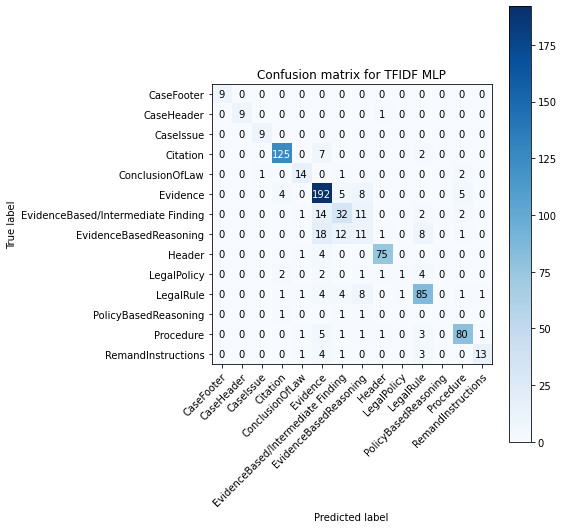

In [266]:
plot_confusion_matrix(test_spans_labels, tfidf_clf_mlp.predict(tfidf_test_X), classes=list(tfidf_clf_mlp.classes_),
                      title='Confusion matrix for TFIDF MLP')
plt.show()

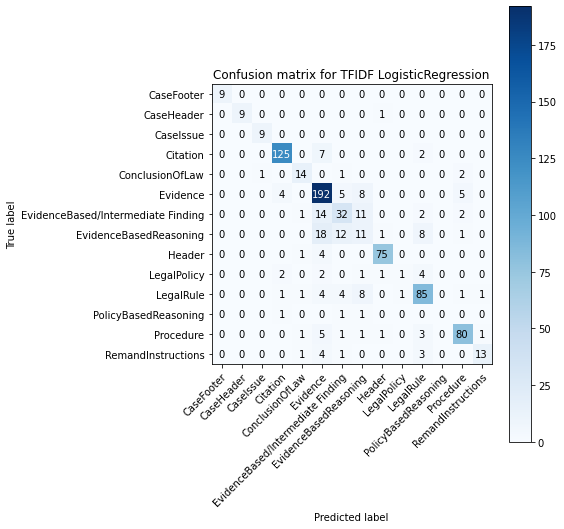

In [267]:
plot_confusion_matrix(test_spans_labels, tfidf_clf_mlp.predict(tfidf_test_X), classes=list(tfidf_clf_lr.classes_),
                      title='Confusion matrix for TFIDF LogisticRegression')
plt.show()

In [279]:
prediction_errors(tfidf_clf_mlp,
                  test_spans,
                  'tfidf',
                  spacy_tfidf_vectorizer, model,
                  select_pred_label='EvidenceBasedReasoning',
                  select_true_label='Evidence')

sentence # 257 / case 1100174.txt / @8540
pred: EvidenceBasedReasoning / true: Evidence
There are two medical opinions of record on the relationship 
between the Veteran's in-service injury and his currently 
diagnosed back disorder.

sentence # 386 / case 1418226.txt / @5507
pred: EvidenceBasedReasoning / true: Evidence
 There is only 'limited or suggestive' evidence of association not meeting the level of causation."

sentence # 391 / case 1418226.txt / @6572
pred: EvidenceBasedReasoning / true: Evidence
There are conflicting medical opinions regarding a nexus between the Veteran's CLL and his acknowledged exposure to contaminants in the water supply where he was stationed in service.

sentence # 392 / case 1418226.txt / @6757
pred: EvidenceBasedReasoning / true: Evidence
The VA examiner's opinion (by a family practitioner) against the claim concedes there may be a nexus, but observes that the evidence of such has not yet reached "the level of causation".

sentence # 721 / case 12051

In [288]:
prediction_errors(tfidf_clf_mlp,
                  test_spans,
                  'tfidf',
                  spacy_tfidf_vectorizer, model,
                  select_true_label='EvidenceBasedReasoning',
                  select_pred_label='Evidence')

sentence # 87 / case 0831180.txt / @2383
pred: Evidence / true: EvidenceBasedReasoning
The credibility of that underlying history is called 
into question because the opinion derived from them 
references an inaccurate date of discharge.

sentence # 88 / case 0831180.txt / @2537
pred: Evidence / true: EvidenceBasedReasoning
Nonetheless, the 
veteran has raised the possibility that his negative 
performance evaluations and administrative remarks show 
symptoms of his current mental disorder sufficient to 
establish chronicity.  

sentence # 184 / case 0709343.txt / @18381
pred: Evidence / true: EvidenceBasedReasoning
However, the 
physician wrote in the past tense and did not provide 
specific details as to the date(s) of the veteran's diagnosis 
of malaria, nor did he relate the veteran's malaria to active 
service or any incident of active duty.

sentence # 206 / case 0709343.txt / @22757
pred: Evidence / true: EvidenceBasedReasoning
(Emphasis added.)

sentence # 277 / case 1100174.tx

In [291]:
prediction_errors(tfidf_clf_mlp,
                  test_spans,
                  'tfidf',
                  spacy_tfidf_vectorizer, model,
                  select_true_label='Evidence',
                  select_pred_label='EvidenceBased/Intermediate Finding')

sentence # 105 / case 0709343.txt / @5664
pred: EvidenceBased/Intermediate Finding / true: Evidence
Written notice provided 
in February 2003 and July 2006 fulfills the provisions of 
38 U.S.C.A. � 5103(a).

sentence # 239 / case 1100174.txt / @6181
pred: EvidenceBased/Intermediate Finding / true: Evidence
The competent medical evidence of record shows that the Veteran 
has a currently diagnosed lower back disability. 

sentence # 376 / case 1418226.txt / @3462
pred: EvidenceBased/Intermediate Finding / true: Evidence
CLL was not manifested during service or within one year following the Veteran's discharge from active duty.

sentence # 441 / case 1641334.txt / @3299
pred: EvidenceBased/Intermediate Finding / true: Evidence
The Board also notes that actions requested in the prior remands have been undertaken.

sentence # 533 / case 1641334.txt / @17633
pred: EvidenceBased/Intermediate Finding / true: Evidence
It is unclear whether this addendum letter was intended to serve as rationale

In [ ]:
select_true_label='Evidence',
                  select_pred_label='EvidenceBased/Intermediate Finding'

In [292]:
prediction_errors(tfidf_clf_mlp,
                  test_spans,
                  'tfidf',
                  spacy_tfidf_vectorizer, model,
                  select_true_label='EvidenceBasedReasoning',
                  select_pred_label='EvidenceBased/Intermediate Finding')

sentence # 199 / case 0709343.txt / @21003
pred: EvidenceBased/Intermediate Finding / true: EvidenceBasedReasoning
When 
there have been relapses following the initial course of 
treatment, further relapses are to be expected and for some 
time the veteran must be given the benefit of the doubt as to 
unexplained fever of short duration, controlled by medication 
specific for malaria.  

sentence # 201 / case 0709343.txt / @21619
pred: EvidenceBased/Intermediate Finding / true: EvidenceBasedReasoning
As to the question of whether there is a current diagnosis of 
malaria, to include recurrent episodes or residuals of 
malaria, the more recent medical opinion is of greater 
probative value. 

sentence # 275 / case 1100174.txt / @12366
pred: EvidenceBased/Intermediate Finding / true: EvidenceBasedReasoning
Therefore, the 
Veteran's credibility is not brought into question because the 
evidence indicates that the event he claimed to not recall did 
not actually occur.

sentence # 276 / cas

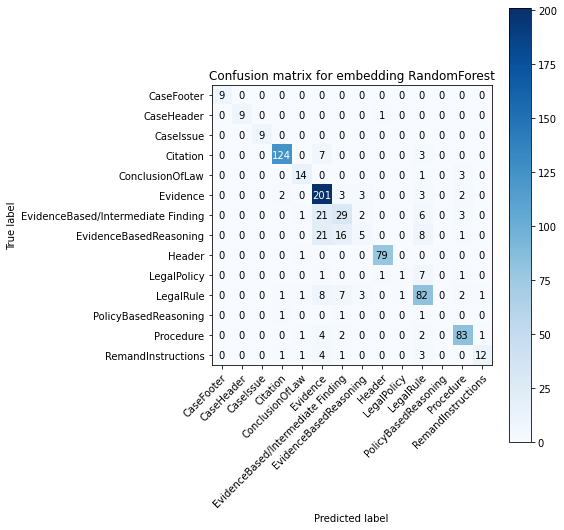

In [270]:
plot_confusion_matrix(test_spans_labels, embedding_clf_rf.predict(embedding_test_X), classes=list(embedding_clf_rf.classes_),
                      title='Confusion matrix for embedding RandomForest')
plt.show()

In [286]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_pred_label='EvidenceBasedReasoning',
                  select_true_label='Evidence')

sentence # 266 / case 1100174.txt / @9967
pred: EvidenceBasedReasoning / true: Evidence
The examiner provided the opinion that it was less 
likely than not that the Veteran's chronic low back had its 
clinical onset during service or is otherwise related to any in-
service disease or injury because there was inadequate 
documentation to relate the Veteran's current symptomatology to 
any in-service disease, event, or injury.

sentence # 392 / case 1418226.txt / @6757
pred: EvidenceBasedReasoning / true: Evidence
The VA examiner's opinion (by a family practitioner) against the claim concedes there may be a nexus, but observes that the evidence of such has not yet reached "the level of causation".

sentence # 721 / case 1205178.txt / @7906
pred: EvidenceBasedReasoning / true: Evidence
The Veteran has not made the RO or the Board aware of any additional evidence that needs to be obtained in order to fairly decide his claim



In [289]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_true_label='Evidence',
                  select_pred_label='EvidenceBased/Intermediate Finding')

sentence # 155 / case 0709343.txt / @14174
pred: EvidenceBased/Intermediate Finding / true: Evidence
The veteran's malaria 
was not currently present or active.

sentence # 727 / case 1205178.txt / @8488
pred: EvidenceBased/Intermediate Finding / true: Evidence
The Veteran seeks service connection for a hearing disability claimed as the result of in-service noise exposure. 

sentence # 791 / case 1205178.txt / @19454
pred: EvidenceBased/Intermediate Finding / true: Evidence
Although the Veteran is competent to report in-service acoustic trauma, he is not competent to render a probative (persuasive) opinion on a medical matter. 



In [ ]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'tfi',
                  spacy_tfidf_vectorizer, model,
                  select_pred_label='EvidenceBasedReasoning',
                  select_true_label='Evidence')

In [295]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_pred_label='Evidence',
                  select_true_label='EvidenceBased/Intermediate Finding')

sentence # 17 / case 1100174.txt / @1430
pred: Evidence / true: EvidenceBased/Intermediate Finding
The Veteran's currently diagnosed lower back disorder began 
during his active military service. 

sentence # 80 / case 0831180.txt / @1365
pred: Evidence / true: EvidenceBased/Intermediate Finding
Initially, the Board is unclear on the 
medical qualifications of a licensed professional counselor.  

sentence # 82 / case 0831180.txt / @1671
pred: Evidence / true: EvidenceBased/Intermediate Finding
Regardless, this opinion explicitly 
acknowledges that it is based on a subjective history given 
by the veteran.

sentence # 106 / case 0709343.txt / @5774
pred: Evidence / true: EvidenceBased/Intermediate Finding
That is, the veteran was effectively 
informed to submit all relevant evidence in his possession 
and that he received notice of the evidence needed to 
substantiate his claim; the avenues by which he might obtain 
such evidence, and the allocation of responsibilities between 
himself

In [290]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_true_label='Evidence',
                  select_pred_label='EvidenceBased/Intermediate Finding')

sentence # 155 / case 0709343.txt / @14174
pred: EvidenceBased/Intermediate Finding / true: Evidence
The veteran's malaria 
was not currently present or active.

sentence # 727 / case 1205178.txt / @8488
pred: EvidenceBased/Intermediate Finding / true: Evidence
The Veteran seeks service connection for a hearing disability claimed as the result of in-service noise exposure. 

sentence # 791 / case 1205178.txt / @19454
pred: EvidenceBased/Intermediate Finding / true: Evidence
Although the Veteran is competent to report in-service acoustic trauma, he is not competent to render a probative (persuasive) opinion on a medical matter. 



In [298]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_true_label='PolicyBasedReasoning',)

sentence # 109 / case 0709343.txt / @6556
pred: Citation / true: PolicyBasedReasoning
The Board recognizes that, according to Pelegrini v. 
Principi, 18 Vet. App. 112, 119-20 (2004), proper VCAA notice 
must "precede an initial unfavorable [agency of original 
jurisdiction (AOJ)] decision on a service-connection claim."  

sentence # 197 / case 0709343.txt / @20540
pred: EvidenceBased/Intermediate Finding / true: PolicyBasedReasoning
The Board is cognizant that, under 38 C.F.R. � 4.88 (2006), 
it is critical to recognize the nature of the disease is 
question.

sentence # 209 / case 0709343.txt / @23085
pred: LegalRule / true: PolicyBasedReasoning
 In making this determination, the 
Board has considered the provisions of 38 U.S.C.A. � 5107(b), 
but there is not such a state of approximate balance of the 
positive evidence with the negative evidence to otherwise 
warrant a favorable decision. 



In [299]:
prediction_errors(embedding_clf_rf,
                  test_spans,
                  'embedding',
                  spacy_tfidf_vectorizer, model_cbow,
                  select_true_label='RemandInstructions',)

sentence # 67 / case 0831180.txt / @3101
pred: Evidence / true: RemandInstructions
The veteran's claims folder 
should be made available to and 
reviewed by the examiner.

sentence # 69 / case 0831180.txt / @3423
pred: Evidence / true: RemandInstructions
Additionally, the 
examiner should review the veteran's 
personnel records and provide an 
opinion as to whether the behavior 
described therein evinces symptoms of 
any current mental disorder.

sentence # 318 / case 0836575.txt / @3032
pred: ConclusionOfLaw / true: RemandInstructions
Accordingly, the case is REMANDED for the following action:

sentence # 320 / case 0836575.txt / @3207
pred: EvidenceBased/Intermediate Finding / true: RemandInstructions
This 
letter should address VA's duties to 
notify and assist the veteran with 
regard to direct service connection and 
secondary service connection.  

sentence # 321 / case 0836575.txt / @3365
pred: Evidence / true: RemandInstructions
Specifically, the letter should: 

sentence # 322

# Appendix

### Change Models in luima_sbd

SIMPLE_MODEL = '20180904.crfsuite'

In [58]:
from luima_sbd.sbd_utils import text2sentences
simple_segmenter = text2sentences

simple_seg_results = get_luima_results (documents_by_id, train_doc_id, simple_segmenter)
simple_seg_labels = make_seg_labels(documents_by_id, train_doc_id, simple_seg_results)
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(simple_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(simple_seg_labels), lenient)
print('Error Metrics - sentence level:')
luima_sentence_level_evaluation(train_spans, simple_segmenter)

Error Metrics - strict:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.7827216628775576 | 0.9409161894846434 | 0.8545594232019385 |
|   E   | 0.5092562520298798 | 0.6121014964216005 | 0.5559626521687743 |
|   I   | 0.9965824996914895 | 0.9935124656103134 | 0.9950451146460011 |
+-------+--------------------+--------------------+--------------------+
Error Metrics - lenient:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.8216953556349464 | 0.9877667881311817 | 0.8971100998758939 |
|   E   | 0.8146584388870846 | 0.9791802212101497 | 0.8893747783949888 |
|   I   | 1.0030880906981094 | 0.9999980157411257 | 1.001540669756618  |
+-

INTEGRATING_MODEL = 'sbd_INT.crfsuite'

In [57]:
from luima_sbd.sbd_utils import text2sentences
int_segmenter = text2sentences

int_seg_results = get_luima_results (documents_by_id, train_doc_id, int_segmenter)
int_seg_labels = make_seg_labels(documents_by_id, train_doc_id, int_seg_results)
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(int_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(int_seg_labels), lenient)
print('Error Metrics - sentence level:')
luima_sentence_level_evaluation(train_spans, int_segmenter)

Error Metrics - strict:
+-------+---------------------+---------------------+---------------------+
| Label |      Precision      |        Recall       |       F1-score      |
+-------+---------------------+---------------------+---------------------+
|   S   |  0.8287461773700305 | 0.07053617907339928 | 0.13000719597025667 |
|   E   | 0.46788990825688076 | 0.03981782693558881 |  0.0733900947355798 |
|   I   |  0.9857915017113603 |  0.9995436204588996 |  0.9926199316527147 |
+-------+---------------------+---------------------+---------------------+
Error Metrics - lenient:
+-------+--------------------+---------------------+---------------------+
| Label |     Precision      |        Recall       |       F1-score      |
+-------+--------------------+---------------------+---------------------+
|   S   | 0.8990825688073395 | 0.07652264445601249 | 0.14104101703046293 |
|   E   | 0.8149847094801224 |  0.069355888093689  |  0.1278330735100132 |
|   I   | 0.9862396452425357 |  0.9999980157

SEN_MODEL = 'sbd_SEN.crfsuite'

In [55]:
from luima_sbd.sbd_utils import text2sentences
sen_segmenter = text2sentences

sen_seg_results = get_luima_results (documents_by_id, train_doc_id, sen_segmenter)
sen_seg_labels = make_seg_labels(documents_by_id, train_doc_id, sen_seg_results)
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(sen_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(sen_seg_labels), lenient)
print('Error Metrics - sentence level:')
luima_sentence_level_evaluation(train_spans, sen_segmenter)

Error Metrics - strict:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.8224105461393597 | 0.5683237896928683 | 0.6721563798676313 |
|   E   | 0.5634651600753295 | 0.3893298633702017 | 0.4604848018468642 |
|   I   | 0.9920922856335948 | 0.996766650164247  | 0.9944239748789353 |
+-------+--------------------+--------------------+--------------------+
Error Metrics - lenient:
+-------+--------------------+--------------------+--------------------+
| Label |     Precision      |       Recall       |      F1-score      |
+-------+--------------------+--------------------+--------------------+
|   S   | 0.8736346516007533 | 0.6037220197813639 | 0.7140218562413422 |
|   E   | 0.9060263653483992 | 0.626024723487313  | 0.7404386302424009 |
|   I   | 0.9953084976330181 | 0.9999980157411257 | 0.9976477458595526 |
+-

NSEN_MODEL = 'sbd_NSEN.crfsuite'

In [56]:
from luima_sbd.sbd_utils import text2sentences
nsen_segmenter = text2sentences

nsen_seg_results = get_luima_results (documents_by_id, train_doc_id, nsen_segmenter)
nsen_seg_labels = make_seg_labels(documents_by_id, train_doc_id, nsen_seg_results)
print('Error Metrics - strict:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(nsen_seg_labels), strict)
print('Error Metrics - lenient:')
error_metrics(get_label_sequence(anno_seg_labels), get_label_sequence(nsen_seg_labels), lenient)
print('Error Metrics - sentence level:')
luima_sentence_level_evaluation(train_spans, nsen_segmenter)

Error Metrics - strict:
+-------+--------------------+---------------------+---------------------+
| Label |     Precision      |        Recall       |       F1-score      |
+-------+--------------------+---------------------+---------------------+
|   S   | 0.4579596412556054 | 0.10632483081728267 |  0.172581326573722  |
|   E   | 0.3010089686098655 | 0.06987638256343526 | 0.11342274791424647 |
|   I   | 0.9862562197592706 |  0.9978034254260948 |  0.9919962202866645 |
+-------+--------------------+---------------------+---------------------+
Error Metrics - lenient:
+-------+---------------------+---------------------+--------------------+
| Label |      Precision      |        Recall       |      F1-score      |
+-------+---------------------+---------------------+--------------------+
|   S   | 0.48934977578475336 | 0.11361270171785529 | 0.1844106463878327 |
|   E   |  0.5330717488789237 | 0.12374756018217306 | 0.200865983736403  |
|   I   |  0.988425412901796  |  0.9999980157411257

### unlabeled corpus seg by luima int_model

In [73]:
sents_of_unlabeled_data = seg_unlabeled_data(unlabeled_data, luima_segmenter)

In [74]:
len(sents_of_unlabeled_data)

277586

### TFIDF tuning

In [165]:
tfidf_clf_dt = tree.DecisionTreeClassifier(max_depth=10)
tfidf_clf_dt = tfidf_clf_dt.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF DecisionTree TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_dt.predict(tfidf_train_X)))
print('TFIDF DecisionTree DEV:\n'+classification_report(val_spans_labels, tfidf_clf_dt.predict(tfidf_dev_X)))

TFIDF DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.93      0.96        88
                        CaseHeader       0.99      0.96      0.98        82
                         CaseIssue       0.99      0.97      0.98        77
                          Citation       0.99      0.97      0.98      1019
                   ConclusionOfLaw       0.93      0.46      0.61       169
                          Evidence       0.65      0.90      0.76      2067
EvidenceBased/Intermediate Finding       0.48      0.51      0.49       682
            EvidenceBasedReasoning       0.76      0.10      0.17       526
                            Header       0.89      0.99      0.94       718
                       LegalPolicy       0.93      0.26      0.40        98
                         LegalRule       0.70      0.57      0.63       849
              PolicyBasedReasoning       1.00      0.08      

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
tfidf_clf_dt = tree.DecisionTreeClassifier(max_depth=15)
tfidf_clf_dt = tfidf_clf_dt.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF DecisionTree TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_dt.predict(tfidf_train_X)))
print('TFIDF DecisionTree DEV:\n'+classification_report(val_spans_labels, tfidf_clf_dt.predict(tfidf_dev_X)))
#print('TFIDF DecisionTree TEST:\n'+classification_report(test_spans_labels, tfidf_clf_dt.predict(tfidf_test_X)))

TFIDF DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.97      0.98        88
                        CaseHeader       0.99      0.96      0.98        82
                         CaseIssue       1.00      0.99      0.99        77
                          Citation       1.00      0.99      0.99      1019
                   ConclusionOfLaw       0.92      0.86      0.89       169
                          Evidence       0.76      0.95      0.85      2067
EvidenceBased/Intermediate Finding       0.92      0.62      0.74       682
            EvidenceBasedReasoning       0.64      0.55      0.59       526
                            Header       0.95      0.99      0.97       718
                       LegalPolicy       0.98      0.58      0.73        98
                         LegalRule       0.84      0.80      0.82       849
              PolicyBasedReasoning       1.00      0.44      

In [166]:
tfidf_clf_dt = tree.DecisionTreeClassifier(max_depth=20)
tfidf_clf_dt = tfidf_clf_dt.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF DecisionTree TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_dt.predict(tfidf_train_X)))
print('TFIDF DecisionTree DEV:\n'+classification_report(val_spans_labels, tfidf_clf_dt.predict(tfidf_dev_X)))

TFIDF DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.98      0.98        88
                        CaseHeader       0.99      0.96      0.98        82
                         CaseIssue       1.00      0.99      0.99        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       1.00      0.93      0.96       169
                          Evidence       0.84      0.98      0.91      2067
EvidenceBased/Intermediate Finding       0.97      0.80      0.88       682
            EvidenceBasedReasoning       0.86      0.75      0.80       526
                            Header       0.98      1.00      0.99       718
                       LegalPolicy       0.99      0.74      0.85        98
                         LegalRule       0.93      0.92      0.92       849
              PolicyBasedReasoning       1.00      0.72      

In [167]:
tfidf_clf_dt = tree.DecisionTreeClassifier(max_depth=30)
tfidf_clf_dt = tfidf_clf_dt.fit(tfidf_train_X, tfidf_train_y)
print('TFIDF DecisionTree TRAIN:\n'+classification_report(train_spans_labels, tfidf_clf_dt.predict(tfidf_train_X)))
print('TFIDF DecisionTree DEV:\n'+classification_report(val_spans_labels, tfidf_clf_dt.predict(tfidf_dev_X)))

TFIDF DecisionTree TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      0.99        88
                        CaseHeader       0.99      0.99      0.99        82
                         CaseIssue       1.00      0.99      0.99        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       0.99      0.98      0.98       169
                          Evidence       0.95      0.99      0.97      2067
EvidenceBased/Intermediate Finding       0.98      0.95      0.96       682
            EvidenceBasedReasoning       0.96      0.93      0.95       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       1.00      0.92      0.96        98
                         LegalRule       0.99      0.98      0.98       849
              PolicyBasedReasoning       1.00      0.92      

### Emdedding tuning

In [88]:
embedding_clf_lr = LogisticRegression(max_iter=100)
embedding_clf_lr = embedding_clf_lr.fit(embedding_train_X, embedding_train_y)
print('Embedding LogisticRegression TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_lr.predict(embedding_train_X)))
print('Embedding LogisticRegression DEV:\n'+classification_report(val_spans_labels, embedding_clf_lr.predict(embedding_dev_X)))

Embedding LogisticRegression TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.97      0.95      0.96        88
                        CaseHeader       0.98      0.96      0.97        82
                         CaseIssue       0.90      0.99      0.94        77
                          Citation       0.97      0.99      0.98      1019
                   ConclusionOfLaw       0.81      0.80      0.80       169
                          Evidence       0.80      0.90      0.84      2067
EvidenceBased/Intermediate Finding       0.54      0.51      0.53       682
            EvidenceBasedReasoning       0.44      0.27      0.33       526
                            Header       0.99      0.99      0.99       718
                       LegalPolicy       0.60      0.39      0.47        98
                         LegalRule       0.74      0.82      0.78       849
              PolicyBasedReasoning       0.67      

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
embedding_clf_lr = LogisticRegression(max_iter=150)
embedding_clf_lr = embedding_clf_lr.fit(embedding_train_X, embedding_train_y)
print('Embedding LogisticRegression TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_lr.predict(embedding_train_X)))
print('Embedding LogisticRegression DEV:\n'+classification_report(val_spans_labels, embedding_clf_lr.predict(embedding_dev_X)))

Embedding LogisticRegression TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.98      0.98      0.98        88
                        CaseHeader       0.98      0.98      0.98        82
                         CaseIssue       0.93      0.99      0.96        77
                          Citation       0.97      0.99      0.98      1019
                   ConclusionOfLaw       0.80      0.79      0.80       169
                          Evidence       0.80      0.90      0.84      2067
EvidenceBased/Intermediate Finding       0.54      0.51      0.53       682
            EvidenceBasedReasoning       0.44      0.26      0.32       526
                            Header       0.99      0.99      0.99       718
                       LegalPolicy       0.60      0.34      0.43        98
                         LegalRule       0.75      0.83      0.79       849
              PolicyBasedReasoning       0.75      

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [104]:
embedding_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=12)
embedding_clf_rf = embedding_clf_rf.fit(embedding_train_X, embedding_train_y)
print('Embedding RandomForest TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_rf.predict(embedding_train_X)))
print('Embedding RandomForest DEV:\n'+classification_report(val_spans_labels, embedding_clf_rf.predict(embedding_dev_X)))

Embedding RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.97      0.98        88
                        CaseHeader       0.99      0.99      0.99        82
                         CaseIssue       1.00      0.99      0.99        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       0.96      0.89      0.93       169
                          Evidence       0.86      0.99      0.92      2067
EvidenceBased/Intermediate Finding       0.88      0.84      0.86       682
            EvidenceBasedReasoning       0.99      0.62      0.76       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       0.98      0.44      0.61        98
                         LegalRule       0.89      0.97      0.92       849
              PolicyBasedReasoning       1.00      0.16  

In [103]:
embedding_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
embedding_clf_rf = embedding_clf_rf.fit(embedding_train_X, embedding_train_y)
print('Embedding RandomForest TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_rf.predict(embedding_train_X)))
print('Embedding RandomForest DEV:\n'+classification_report(val_spans_labels, embedding_clf_rf.predict(embedding_dev_X)))

Embedding RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      0.99        88
                        CaseHeader       0.99      1.00      0.99        82
                         CaseIssue       1.00      1.00      1.00        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       0.98      0.97      0.98       169
                          Evidence       0.95      1.00      0.98      2067
EvidenceBased/Intermediate Finding       0.98      0.96      0.97       682
            EvidenceBasedReasoning       1.00      0.89      0.94       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       1.00      0.81      0.89        98
                         LegalRule       0.96      0.99      0.98       849
              PolicyBasedReasoning       1.00      0.80  

In [105]:
embedding_clf_rf = RandomForestClassifier(n_estimators=100, max_depth=17)
embedding_clf_rf = embedding_clf_rf.fit(embedding_train_X, embedding_train_y)
print('Embedding RandomForest TRAIN:\n'+classification_report(train_spans_labels, embedding_clf_rf.predict(embedding_train_X)))
print('Embedding RandomForest DEV:\n'+classification_report(val_spans_labels, embedding_clf_rf.predict(embedding_dev_X)))

Embedding RandomForest TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      0.99        88
                        CaseHeader       0.99      1.00      0.99        82
                         CaseIssue       1.00      1.00      1.00        77
                          Citation       1.00      1.00      1.00      1019
                   ConclusionOfLaw       1.00      1.00      1.00       169
                          Evidence       0.98      1.00      0.99      2067
EvidenceBased/Intermediate Finding       1.00      0.98      0.99       682
            EvidenceBasedReasoning       1.00      0.96      0.98       526
                            Header       1.00      1.00      1.00       718
                       LegalPolicy       1.00      0.97      0.98        98
                         LegalRule       0.99      0.99      0.99       849
              PolicyBasedReasoning       1.00      1.00  

### CRF

In [141]:
train_by_doc = [(s for s in train_spans if s['document']==doc_id)for doc_id in train_doc_id]
val_by_doc = [(s for s in val_spans if s['document']==doc_id)for doc_id in val_doc_id]
test_by_doc = [(s for s in test_spans if s['document']==doc_id)for doc_id in test_doc_id]

In [194]:
num_tokens = np.array([len(s['tokens_spacy']) for s in train_spans])
mean = np.mean(num_tokens)
std = np.std(num_tokens)

In [192]:
print(mean)
print(std)

21.543278084714547
16.051778645153245


In [143]:
def make_crf_embedding_features_and_labels(docs, model):
    X, x = [], []
    Y, y = [], []
    for doc in docs:
        for s in doc:
            tokens = s['tokens_spacy']
            embedding = 0
            for t in tokens:
                embedding = embedding + model.get_word_vector(t)
            embedding = embedding/len(tokens)
            start_normalized = s['start_normalized']
            num_tokens_normalized = (len(tokens)-mean)/std
            
            temp = {}
            for i, value in enumerate(embedding):
                temp['embedding{}'.format(i)]=value
            temp['start_normalized'] = start_normalized
            temp['num_tokens_normalized'] = num_tokens_normalized
            x.append(temp)
            y.append(s['type'])
        X.append(x)
        Y.append(y)
    return X, Y

In [144]:
model = model_cbow
embedding_train_crf_X, embedding_train_crf_y = make_crf_embedding_features_and_labels(train_by_doc, model)
embedding_dev_crf_X, embedding_dev_crf_y = make_crf_embedding_features_and_labels(val_by_doc, model)
embedding_test_crf_X, embedding_test_crf_y = make_crf_embedding_features_and_labels(test_by_doc, model)

In [145]:
embedding_train_crf_X[0][0]

{'embedding0': -3.173502,
 'embedding1': 1.2340724,
 'embedding2': -1.6006254,
 'embedding3': 0.53549105,
 'embedding4': 0.33005765,
 'embedding5': -1.1178182,
 'embedding6': 0.51504135,
 'embedding7': -1.7267102,
 'embedding8': -0.20423292,
 'embedding9': -2.1178398,
 'embedding10': 0.27733684,
 'embedding11': 0.36930895,
 'embedding12': -1.1288037,
 'embedding13': -0.096231565,
 'embedding14': -1.8704205,
 'embedding15': 1.559106,
 'embedding16': -0.45986122,
 'embedding17': 0.33987123,
 'embedding18': -0.31783867,
 'embedding19': 0.65953314,
 'embedding20': -0.37326312,
 'embedding21': 0.47081232,
 'embedding22': 0.449467,
 'embedding23': -0.19055781,
 'embedding24': 0.40410703,
 'embedding25': -1.338053,
 'embedding26': 0.26926005,
 'embedding27': 0.17706165,
 'embedding28': -0.025374383,
 'embedding29': 1.0843482,
 'embedding30': 1.2601892,
 'embedding31': 1.1890724,
 'embedding32': 0.23650797,
 'embedding33': 0.065915056,
 'embedding34': 0.57429755,
 'embedding35': -0.9493773,
 '

In [146]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

embedding_clf_crf = sklearn_crfsuite.CRF(algorithm='lbfgs', 
                                     c1=0.1,
                                     c2=0.1,
                                     max_iterations=150,
                                     all_possible_transitions=True)

embedding_clf_crf = embedding_clf_crf.fit(embedding_train_crf_X, embedding_train_crf_y)
labels = list(embedding_clf_crf.classes_)
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
y_pred = embedding_clf_crf.predict(embedding_dev_crf_X)
print('Embedding CRF test:')
print(metrics.flat_classification_report(embedding_dev_crf_y, y_pred, labels=sorted_labels, digits=2))

Embedding CRF test:
                                    precision    recall  f1-score   support

                        CaseHeader       1.00      1.00      1.00        81
                         Procedure       0.50      0.88      0.64       648
                            Header       0.86      0.86      0.86       567
                         CaseIssue       1.00      1.00      1.00        81
                          Citation       1.00      1.00      1.00       162
                        CaseFooter       1.00      1.00      1.00        81
EvidenceBased/Intermediate Finding       0.00      0.00      0.00       162
                          Evidence       0.00      0.00      0.00       243
                         LegalRule       1.00      1.00      1.00       243
                RemandInstructions       1.00      0.50      0.67       162

                          accuracy                           0.73      2430
                         macro avg       0.74      0.72      0.72 

/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['CaseHeader', 'Procedure', 'Header', 'CaseIssue', 'Citation', 'CaseFooter', 'EvidenceBased/Intermediate Finding', 'Evidence', 'LegalRule', 'RemandInstructions'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ldsi/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z